In [2]:
import sys
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/poc")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/dags")

#Import libs python
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date

#Import libs internas
from utils import spark_utils_session as utils

from hooks.hdfs.hdfs_helper import HdfsHelper
from jobs.job_base_config import BaseETLJobClass

import poc_helper
poc_helper.load_env("PROD")

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/airflow_metastore_helper.py:10 DeprecatedImportWarning: The `airflow.utils.xcom.XCOM_RETURN_KEY` attribute is deprecated. Please use `'airflow.models.xcom.XCOM_RETURN_KEY'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/impala_helper.py:6 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/postgres_helper.py:4 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

'.env_file' loaded!
ENV 'PROD' configured!


In [3]:
def get_session(profile: str, dynamic_allocation_enabled: bool = True) -> utils.DBASparkAppSession:
    """Generates DBASparkAppSession."""
    
    app_name = "tsevero_gei"
    
    spark_builder = (utils.DBASparkAppSession
                     .builder
                     .setAppName(app_name)
                     .usingProcessProfile(profile)
                    )
    
    if dynamic_allocation_enabled:
        spark_builder.autoResourceManagement()

    return spark_builder.build()

session = get_session(profile='efd_t2')

2025-10-09T18:34:54.018482Z [info     ] Using json file settings.      [root] loc=spark_utils_session.py:301
2025-10-09T18:34:54.019808Z [info     ] Exporting default ENV.         [root] loc=spark_utils_session.py:305
2025-10-09T18:34:54.020199Z [info     ] Exporting custom ENVs.         [root] loc=spark_utils_session.py:338
2025-10-09T18:34:54.020643Z [info     ] Building profile 'efd_t2'.     [root] loc=spark_utils_session.py:221
2025-10-09T18:34:54.021011Z [info     ] Not enough info for building the kerberos client. Ignoring it [root] loc=spark_utils_session.py:284


:: loading settings :: url = jar:file:/opt/cloudera/parcels/SPARK3-3.5.4.3.5.7191000.0-30-1.p0.68499982/lib/spark3/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tsevero/.ivy2/cache
The jars for the packages stored in: /home/tsevero/.ivy2/jars
com.databricks#spark-xml_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
com.oracle.database.security#oraclepki added as a dependency
com.oracle.database.security#osdt_core added as a dependency
com.oracle.database.security#osdt_cert added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a1ae4214-3dbe-47d4-b3f8-8fe3e5e28e35;1.0
	confs: [default]
	found com.databricks#spark-xml_2.12;0.18.0 in central
	found commons-io#commons-io;2.11.0 in central
	found org.glassfish.jaxb#txw2;3.0.2 in central
	found org.apache.ws.xmlschema#xmlschema-core;2.3.0 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.9.0 in central
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.9.2 in central
	found com.oracle.database.security#oraclepki;21.18.0.0 in central
	found com.oracle.databa

In [4]:
session.sparkSession.sql("SHOW DATABASES").show(truncate=False)

Hive Session ID = d777bc59-44f7-4a84-915e-294d4fae390d


+------------------+
|namespace         |
+------------------+
|anac              |
|bcadastro         |
|bpe               |
|c115              |
|ccc               |
|ccg               |
|cte               |
|default           |
|destda            |
|detran_share      |
|dime              |
|due               |
|efd               |
|fci               |
|gecob             |
|gescol            |
|gessimples        |
|gplam             |
|information_schema|
|malhas            |
+------------------+
only showing top 20 rows



In [5]:
# Bibliotecas para análise e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# Acesso ao SparkSession
spark = session.sparkSession

print("=" * 80)
print("SISTEMA DE ANÁLISE GEI - Gestão de Empresas e Indícios Fiscais")
print("=" * 80)
print(f"Sessão Spark: {spark.sparkContext.appName}")
print(f"Versão Spark: {spark.version}")
print(f"Iniciado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

SISTEMA DE ANÁLISE GEI - Gestão de Empresas e Indícios Fiscais
Sessão Spark: tsevero_gei
Versão Spark: 3.5.4.3.5.7191000.0-30
Iniciado em: 2025-10-09 15:37:30


In [6]:
print("\n" + "=" * 80)
print("VERIFICAÇÃO DE TABELAS DISPONÍVEIS")
print("=" * 80)

# Lista de tabelas esperadas
tabelas_esperadas = [
    'gessimples.gei_percent',
    'gessimples.gei_cnpj',
    'gessimples.gei_nfe_completo',
    'gessimples.gei_cadastro',
    'gessimples.gei_contador',
    'gessimples.gei_socios_metricas',
    'gessimples.gei_c115_ranking_risco_grupo_economico',
    'gessimples.gei_indicios_metricas_grupo',
    'gessimples.gei_pagamentos_metricas_grupo',
    'gessimples.gei_funcionarios_metricas_grupo'
]

print("\nVerificando tabelas do sistema GEI:\n")
for tabela in tabelas_esperadas:
    try:
        count = spark.sql(f"SELECT COUNT(*) as cnt FROM {tabela}").collect()[0]['cnt']
        print(f"✓ {tabela:60s} -> {count:,} registros")
    except Exception as e:
        print(f"✗ {tabela:60s} -> NÃO ENCONTRADA")

print("\n" + "=" * 80)


VERIFICAÇÃO DE TABELAS DISPONÍVEIS

Verificando tabelas do sistema GEI:



✓ gessimples.gei_percent                                       -> 626 registros
✓ gessimples.gei_cnpj                                          -> 1,795 registros
✓ gessimples.gei_nfe_completo                                  -> 37,716,812 registros
✓ gessimples.gei_cadastro                                      -> 1,114 registros
✓ gessimples.gei_contador                                      -> 538 registros
✓ gessimples.gei_socios_metricas                               -> 629 registros
✓ gessimples.gei_c115_ranking_risco_grupo_economico            -> 629 registros
✓ gessimples.gei_indicios_metricas_grupo                       -> 619 registros
✓ gessimples.gei_pagamentos_metricas_grupo                     -> 610 registros
✓ gessimples.gei_funcionarios_metricas_grupo                   -> 616 registros




1. PANORAMA GERAL DO SISTEMA GEI



MÉTRICAS PRINCIPAIS:
  Total de Grupos Monitorados: 626
  Total de CNPJs: 1,788
  Score Médio de Risco: 31.51
  Score Máximo Detectado: 79.66

DISTRIBUIÇÃO DE RISCO:
  Grupos Críticos (≥20): 459
  Grupos Alto Risco (15-20): 40
  Grupos Médio Risco (10-15): 59

IMPACTO FINANCEIRO:
  Receita Total Monitorada: R$ 617,871,581.71
  Grupos Acima Limite SN: 71


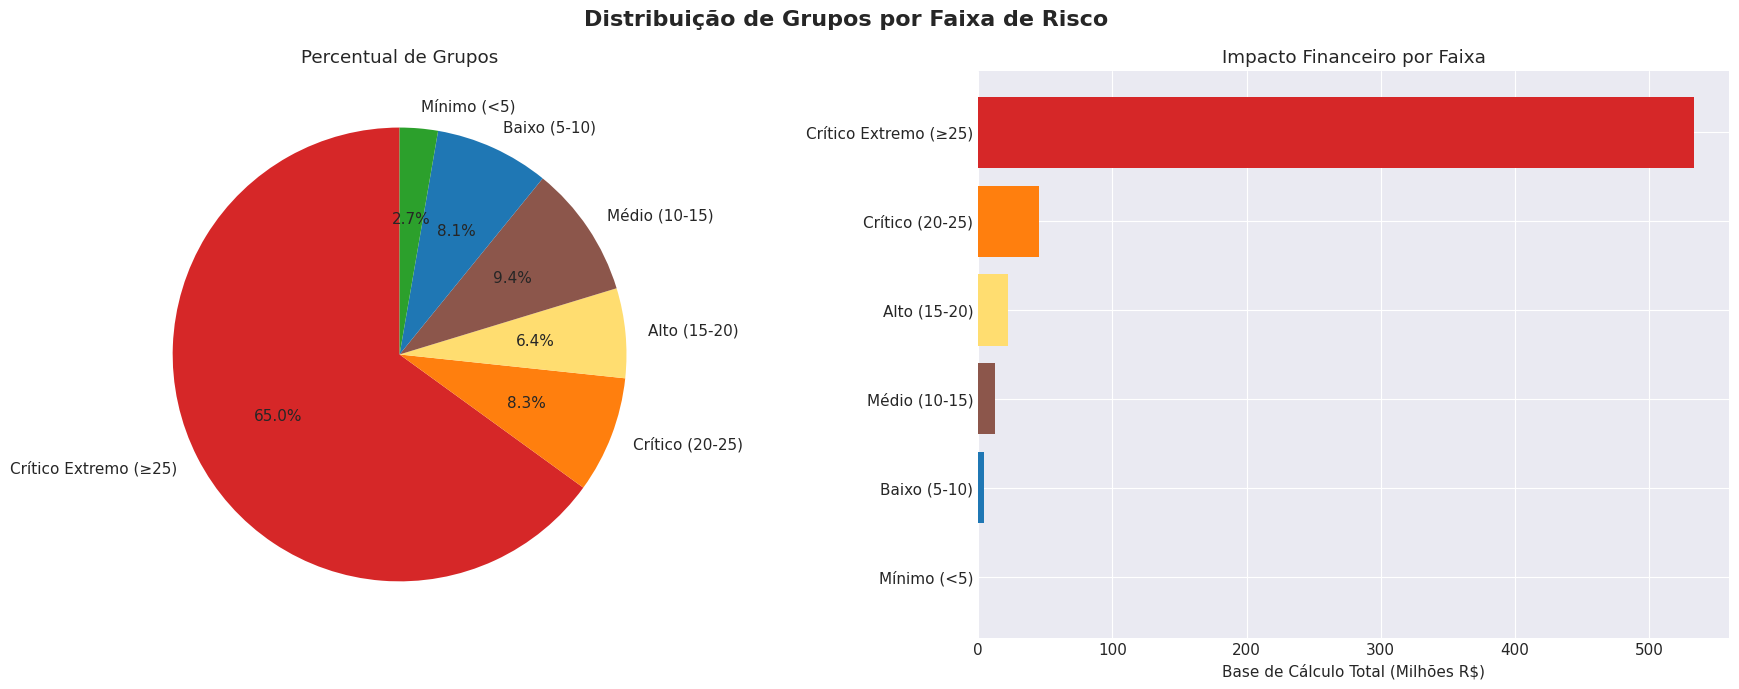

In [7]:
print("\n" + "=" * 80)
print("1. PANORAMA GERAL DO SISTEMA GEI")
print("=" * 80)

query_panorama = """
SELECT 
    COUNT(DISTINCT num_grupo) AS total_grupos,
    SUM(qntd_cnpj) AS total_cnpjs,
    ROUND(AVG(score_final_avancado), 2) AS score_medio,
    ROUND(MAX(score_final_avancado), 2) AS score_maximo,
    COUNT(CASE WHEN score_final_avancado >= 20 THEN 1 END) AS grupos_criticos,
    COUNT(CASE WHEN score_final_avancado >= 15 AND score_final_avancado < 20 THEN 1 END) AS grupos_alto_risco,
    COUNT(CASE WHEN score_final_avancado >= 10 AND score_final_avancado < 15 THEN 1 END) AS grupos_medio_risco,
    SUM(COALESCE(valor_max, 0)) AS receita_total_monitorada,
    COUNT(CASE WHEN valor_max >= 4800000 THEN 1 END) AS grupos_acima_limite_sn
FROM gessimples.gei_percent
"""

df_panorama = spark.sql(query_panorama)
panorama = df_panorama.collect()[0]

print(f"\nMÉTRICAS PRINCIPAIS:")
print(f"  Total de Grupos Monitorados: {panorama['total_grupos']:,}")
print(f"  Total de CNPJs: {panorama['total_cnpjs']:,}")
print(f"  Score Médio de Risco: {panorama['score_medio']:.2f}")
print(f"  Score Máximo Detectado: {panorama['score_maximo']:.2f}")
print(f"\nDISTRIBUIÇÃO DE RISCO:")
print(f"  Grupos Críticos (≥20): {panorama['grupos_criticos']:,}")
print(f"  Grupos Alto Risco (15-20): {panorama['grupos_alto_risco']:,}")
print(f"  Grupos Médio Risco (10-15): {panorama['grupos_medio_risco']:,}")
print(f"\nIMPACTO FINANCEIRO:")
print(f"  Receita Total Monitorada: R$ {panorama['receita_total_monitorada']:,.2f}")
print(f"  Grupos Acima Limite SN: {panorama['grupos_acima_limite_sn']:,}")

# Gráfico de Distribuição por Faixa de Risco
dist_risco = spark.sql("""
SELECT 
    CASE 
        WHEN score_final_avancado >= 25 THEN 'Crítico Extremo (≥25)'
        WHEN score_final_avancado >= 20 THEN 'Crítico (20-25)'
        WHEN score_final_avancado >= 15 THEN 'Alto (15-20)'
        WHEN score_final_avancado >= 10 THEN 'Médio (10-15)'
        WHEN score_final_avancado >= 5 THEN 'Baixo (5-10)'
        ELSE 'Mínimo (<5)'
    END AS faixa_risco,
    COUNT(*) AS quantidade,
    SUM(COALESCE(valor_max, 0)) AS bc_total
FROM gessimples.gei_percent
GROUP BY 1
ORDER BY MIN(score_final_avancado) DESC
""").toPandas()

dist_risco['bc_total'] = dist_risco['bc_total'].astype(float)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Distribuição de Grupos por Faixa de Risco', fontsize=16, fontweight='bold')

colors = ['#d62728', '#ff7f0e', '#ffdd70', '#8c564b', '#1f77b4', '#2ca02c']
ax1.pie(dist_risco['quantidade'], labels=dist_risco['faixa_risco'], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Percentual de Grupos')

ax2.barh(dist_risco['faixa_risco'], dist_risco['bc_total']/1e6, color=colors)
ax2.set_xlabel('Base de Cálculo Total (Milhões R$)')
ax2.set_title('Impacto Financeiro por Faixa')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


2. RANKING: TOP 30 GRUPOS DE MAIOR RISCO


2025-10-09T18:37:47.812015Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-09T18:37:47.813244Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224



TOP 30 GRUPOS POR SCORE DE RISCO:

 1. Grupo 995
    Score Final: 79.66 | CNPJs: 2
    Receita: R$ nan | Funcionários: 78
    Nível Risco C115: INEXISTENTE

 2. Grupo 1344
    Score Final: 72.76 | CNPJs: 2
    Receita: R$ 5,869,675.66 | Funcionários: 26
    Nível Risco C115: INEXISTENTE

 3. Grupo 1383
    Score Final: 71.81 | CNPJs: 3
    Receita: R$ nan | Funcionários: 129
    Nível Risco C115: INEXISTENTE

 4. Grupo 125
    Score Final: 70.67 | CNPJs: 6
    Receita: R$ nan | Funcionários: 121
    Nível Risco C115: MÉDIO

 5. Grupo 5
    Score Final: 66.58 | CNPJs: 2
    Receita: R$ 4,138,054.90 | Funcionários: 1
    Nível Risco C115: INEXISTENTE

 6. Grupo 624
    Score Final: 66.42 | CNPJs: 4
    Receita: R$ nan | Funcionários: 14
    Nível Risco C115: INEXISTENTE

 7. Grupo 1330
    Score Final: 65.24 | CNPJs: 3
    Receita: R$ nan | Funcionários: 55
    Nível Risco C115: INEXISTENTE

 8. Grupo 409
    Score Final: 64.18 | CNPJs: 2
    Receita: R$ nan | Funcionários: 138
    Níve

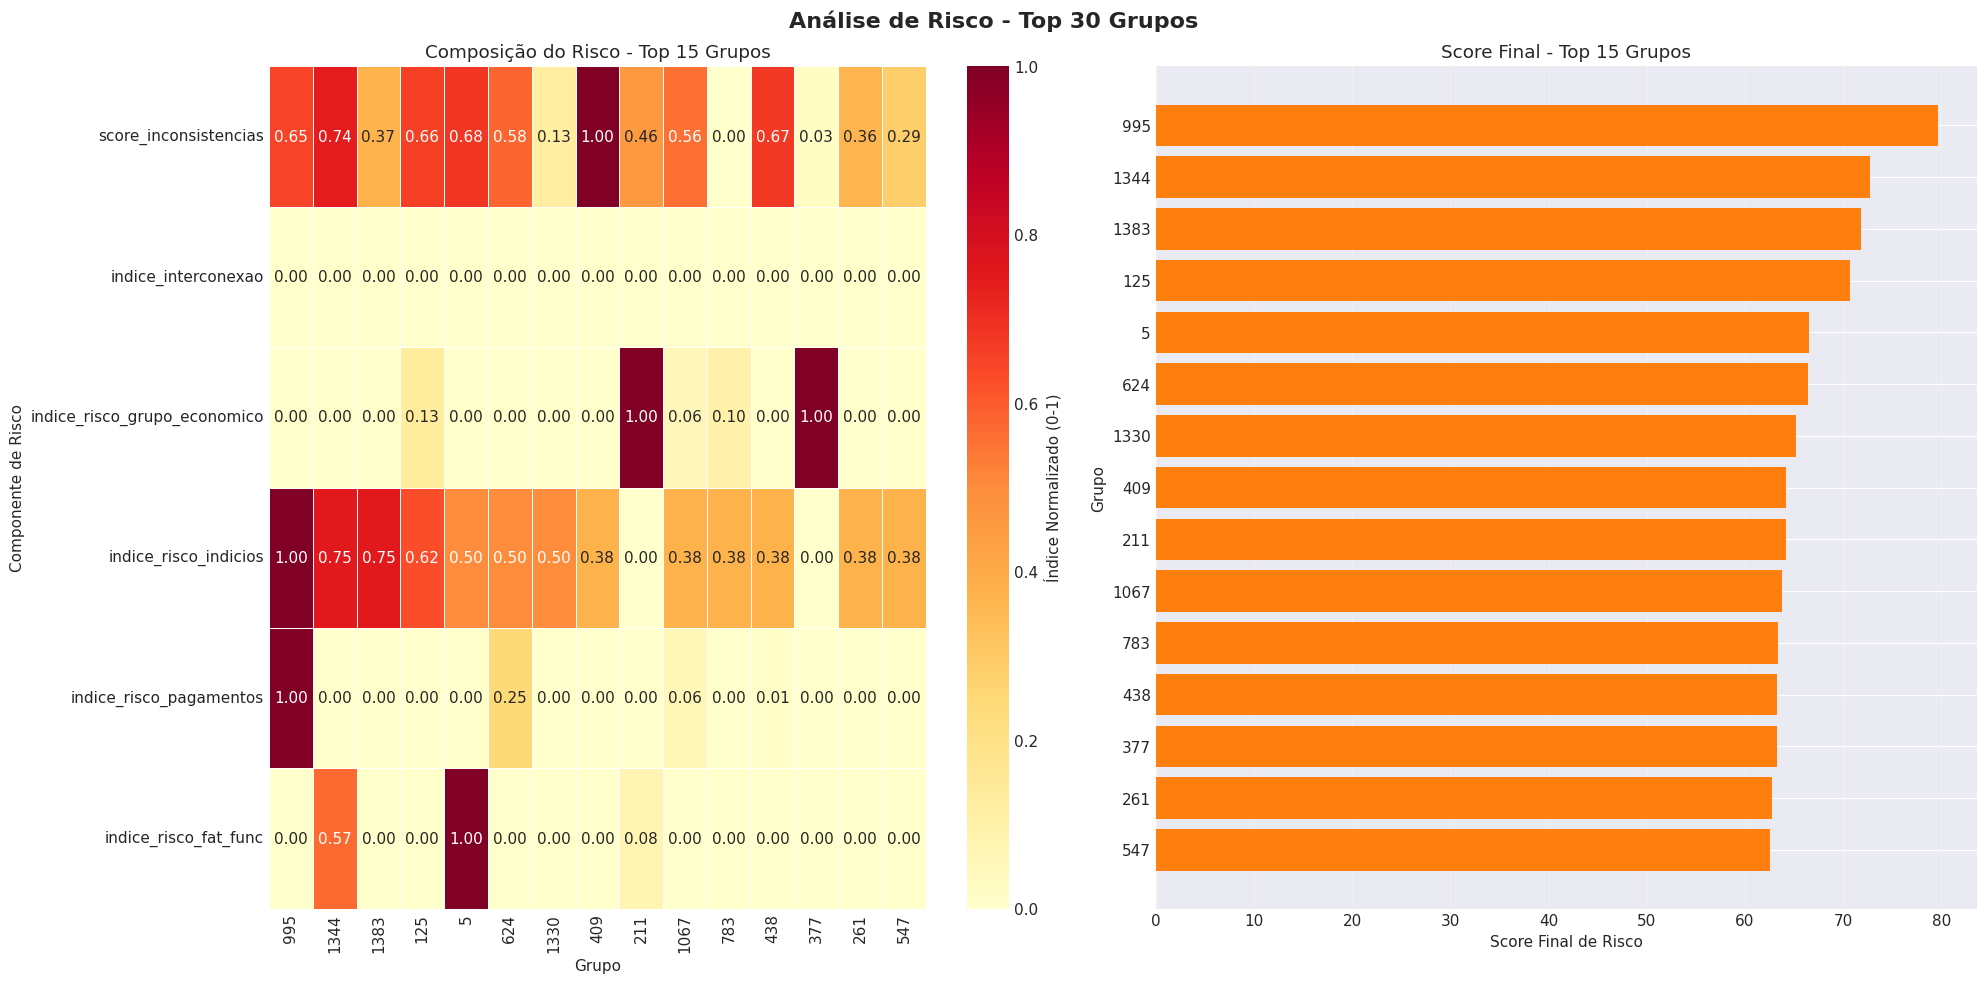

In [8]:
print("\n" + "=" * 80)
print("2. RANKING: TOP 30 GRUPOS DE MAIOR RISCO")
print("=" * 80)

query_ranking = """
SELECT 
    num_grupo,
    qntd_cnpj,
    score_final_avancado,
    valor_max,
    total_funcionarios,
    nivel_risco_grupo_economico,
    
    -- Componentes individuais do score
    total as score_inconsistencias,
    indice_interconexao,
    indice_risco_grupo_economico,
    indice_risco_indicios,
    indice_risco_pagamentos,
    indice_risco_fat_func
    
FROM gessimples.gei_percent
WHERE score_final_avancado IS NOT NULL
ORDER BY score_final_avancado DESC
LIMIT 30
"""

df_ranking = spark.sql(query_ranking).toPandas()

# Converter Decimal para float
numeric_cols = ['valor_max', 'score_final_avancado', 'indice_interconexao', 
                'indice_risco_grupo_economico', 'indice_risco_indicios',
                'indice_risco_pagamentos', 'indice_risco_fat_func']
for col in numeric_cols:
    if col in df_ranking.columns:
        df_ranking[col] = pd.to_numeric(df_ranking[col], errors='coerce')

print("\nTOP 30 GRUPOS POR SCORE DE RISCO:\n")
for idx, row in df_ranking.iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Score Final: {row['score_final_avancado']:.2f} | CNPJs: {int(row['qntd_cnpj'])}")
    print(f"    Receita: R$ {row['valor_max']:,.2f} | Funcionários: {int(row['total_funcionarios'])}")
    print(f"    Nível Risco C115: {row['nivel_risco_grupo_economico'] or 'INEXISTENTE'}")
    print()

# Visualização - Heatmap de componentes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Análise de Risco - Top 30 Grupos', fontsize=16, fontweight='bold')

# Preparar dados para heatmap (Top 15)
risk_components = df_ranking.head(15)[['score_inconsistencias', 'indice_interconexao', 
                                        'indice_risco_grupo_economico', 'indice_risco_indicios',
                                        'indice_risco_pagamentos', 'indice_risco_fat_func']].fillna(0)
risk_components.index = df_ranking.head(15)['num_grupo'].astype(str)

# Normalizar para visualização
risk_components_norm = risk_components.copy()
for col in risk_components_norm.columns:
    col_min = risk_components_norm[col].min()
    col_max = risk_components_norm[col].max()
    if col_max > col_min:
        risk_components_norm[col] = (risk_components_norm[col] - col_min) / (col_max - col_min)
    else:
        risk_components_norm[col] = 0

sns.heatmap(risk_components_norm.T, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Índice Normalizado (0-1)'}, linewidths=0.5, ax=ax1)
ax1.set_title('Composição do Risco - Top 15 Grupos')
ax1.set_xlabel('Grupo')
ax1.set_ylabel('Componente de Risco')

# Gráfico de barras do score final
top15 = df_ranking.head(15).sort_values('score_final_avancado', ascending=True)
colors_risk = ['#8b0000' if x >= 90 else '#d62728' if x >= 80 else '#ff7f0e' 
               for x in top15['score_final_avancado']]
ax2.barh(top15['num_grupo'].astype(str), top15['score_final_avancado'], color=colors_risk)
ax2.set_xlabel('Score Final de Risco')
ax2.set_ylabel('Grupo')
ax2.set_title('Score Final - Top 15 Grupos')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


3. ANÁLISE DE CONTADORES ASSOCIADOS A GRUPOS DE RISCO

TOP 10 CONTADORES COM GRUPOS DE MAIOR RISCO:

 1. ALEXANDRE RAFAEL CARDOSO
    GERFE: GERÊNCIA REGIONAL DE BLUMENAU
    Grupos: 3 | Score Médio: 48.93
    Alto Risco: 0 grupos | CNPJs: 0

 2. ILDO ADAIR OSAIDA
    GERFE: GERÊNCIA REGIONAL DE FLORIANOPOLIS
    Grupos: 3 | Score Médio: 47.24
    Alto Risco: 0 grupos | CNPJs: 0

 3. BRUNO ROBERTO DA SILVA
    GERFE: GERÊNCIA REGIONAL DE JOINVILLE
    Grupos: 5 | Score Médio: 47.18
    Alto Risco: 0 grupos | CNPJs: 0

 4. BRUNO ROBERTO DA SILVA
    GERFE: GERÊNCIA REGIONAL DE ITAJAI
    Grupos: 5 | Score Médio: 47.18
    Alto Risco: 0 grupos | CNPJs: 0

 5. LAERCIO FACHINI
    GERFE: GERÊNCIA REGIONAL DE BLUMENAU
    Grupos: 3 | Score Médio: 46.66
    Alto Risco: 0 grupos | CNPJs: 0

 6. NIZIO JOSE DE OLIVEIRA JUNIOR
    GERFE: GERÊNCIA DE CONTRIBUINTES OUTRAS UFS
    Grupos: 4 | Score Médio: 46.60
    Alto Risco: 0 grupos | CNPJs: 0

 7. SILMAR APARECIDA DA CUNHA SCHMIDT MOREIRA
    

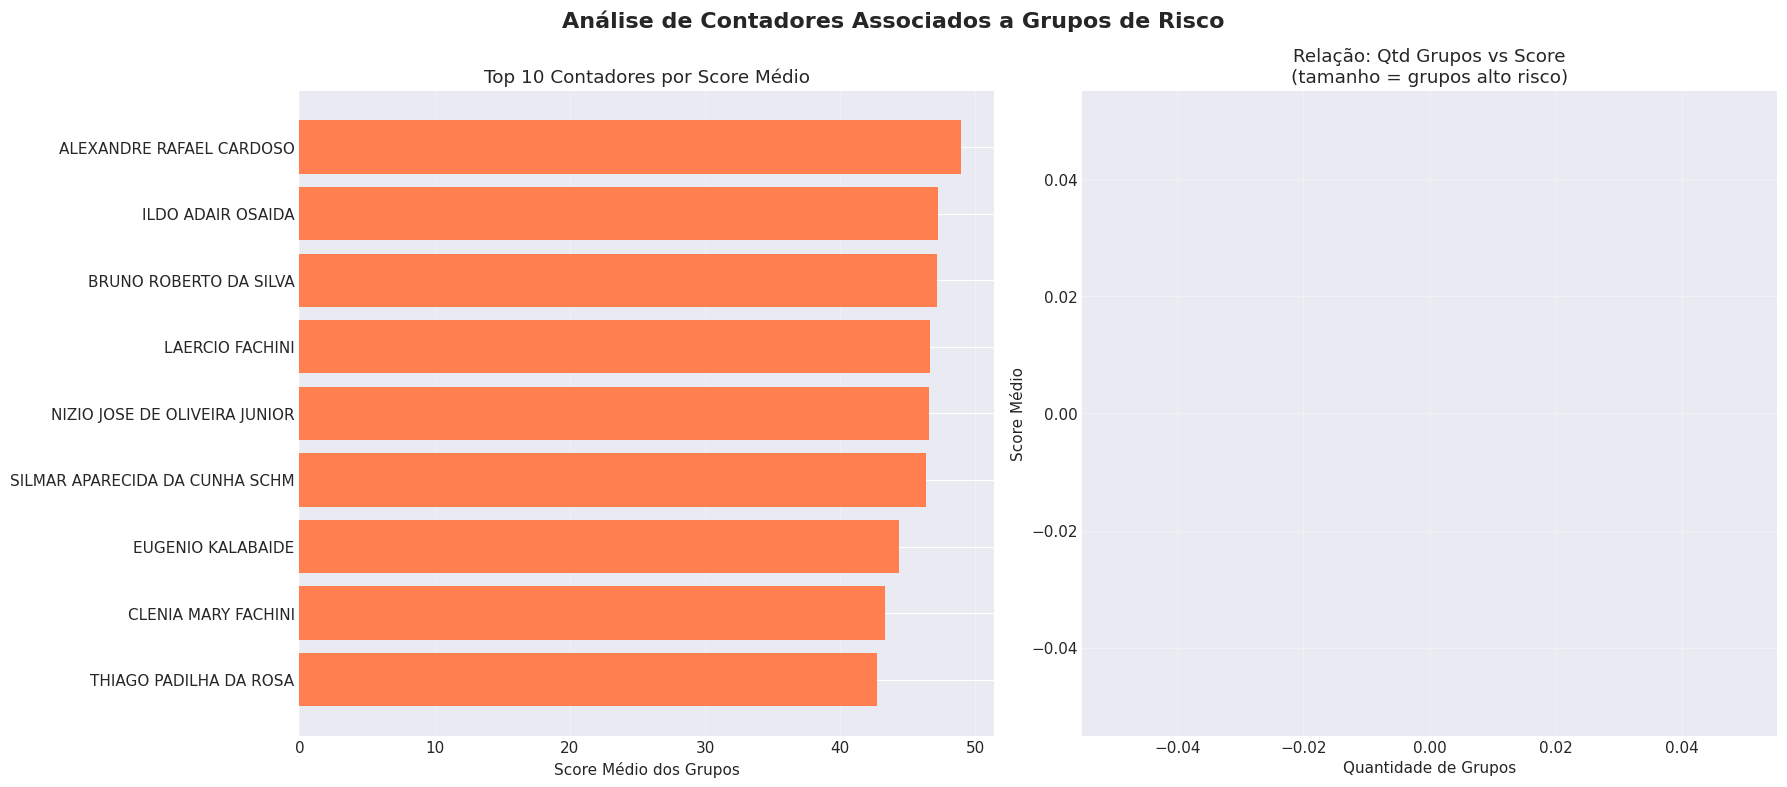

In [9]:
print("\n" + "=" * 80)
print("3. ANÁLISE DE CONTADORES ASSOCIADOS A GRUPOS DE RISCO")
print("=" * 80)

query_contadores = """
SELECT 
    c.nm_contador,
    c.nm_gerfe,
    c.qntd_grupos,
    c.media as score_medio_grupos,
    COUNT(p.num_grupo) as grupos_encontrados,
    SUM(CASE WHEN p.score_final_avancado >= 15 THEN 1 ELSE 0 END) as grupos_alto_risco,
    SUM(p.qntd_cnpj) as total_cnpjs
FROM gessimples.gei_contador c
LEFT JOIN gessimples.gei_percent p ON c.nm_contador = p.nm_contador
WHERE c.qntd_grupos >= 3
GROUP BY c.nm_contador, c.nm_gerfe, c.qntd_grupos, c.media
ORDER BY c.media DESC
LIMIT 20
"""

df_contadores = spark.sql(query_contadores).toPandas()

# Converter e tratar valores
df_contadores['score_medio_grupos'] = pd.to_numeric(df_contadores['score_medio_grupos'], errors='coerce')
df_contadores['grupos_alto_risco'] = df_contadores['grupos_alto_risco'].fillna(0).astype(int)
df_contadores['total_cnpjs'] = df_contadores['total_cnpjs'].fillna(0).astype(int)

print("\nTOP 10 CONTADORES COM GRUPOS DE MAIOR RISCO:\n")
for idx, row in df_contadores.head(10).iterrows():
    print(f"{idx+1:2d}. {row['nm_contador']}")
    print(f"    GERFE: {row['nm_gerfe']}")
    print(f"    Grupos: {int(row['qntd_grupos'])} | Score Médio: {row['score_medio_grupos']:.2f}")
    print(f"    Alto Risco: {row['grupos_alto_risco']} grupos | CNPJs: {row['total_cnpjs']}")
    print()

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise de Contadores Associados a Grupos de Risco', fontsize=16, fontweight='bold')

# Top 10 por score médio
top10_cont = df_contadores.head(10).sort_values('score_medio_grupos', ascending=True)
ax1.barh([x[:30] for x in top10_cont['nm_contador']], top10_cont['score_medio_grupos'], 
         color='coral')
ax1.set_xlabel('Score Médio dos Grupos')
ax1.set_title('Top 10 Contadores por Score Médio')
ax1.grid(True, alpha=0.3, axis='x')

# Scatter: Grupos vs Score
scatter_data = df_contadores[df_contadores['grupos_alto_risco'] > 0]
ax2.scatter(scatter_data['qntd_grupos'], scatter_data['score_medio_grupos'],
            s=scatter_data['grupos_alto_risco']*50, alpha=0.6, c=scatter_data['score_medio_grupos'],
            cmap='Reds', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Quantidade de Grupos')
ax2.set_ylabel('Score Médio')
ax2.set_title('Relação: Qtd Grupos vs Score\n(tamanho = grupos alto risco)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


4. ANÁLISE DETALHADA DE INCONSISTÊNCIAS OPERACIONAIS

PERCENTUAL MÉDIO DE INCONSISTÊNCIAS POR TIPO:

  Fornecedor: 39.62%
  Codigo Produto: 37.49%
  Ip: 35.97%
  Tel Dest: 33.65%
  Email: 21.92%
  Tel Emit: 10.68%
  End Dest: 7.56%
  Cliente: 5.55%
  End Emit: 2.89%


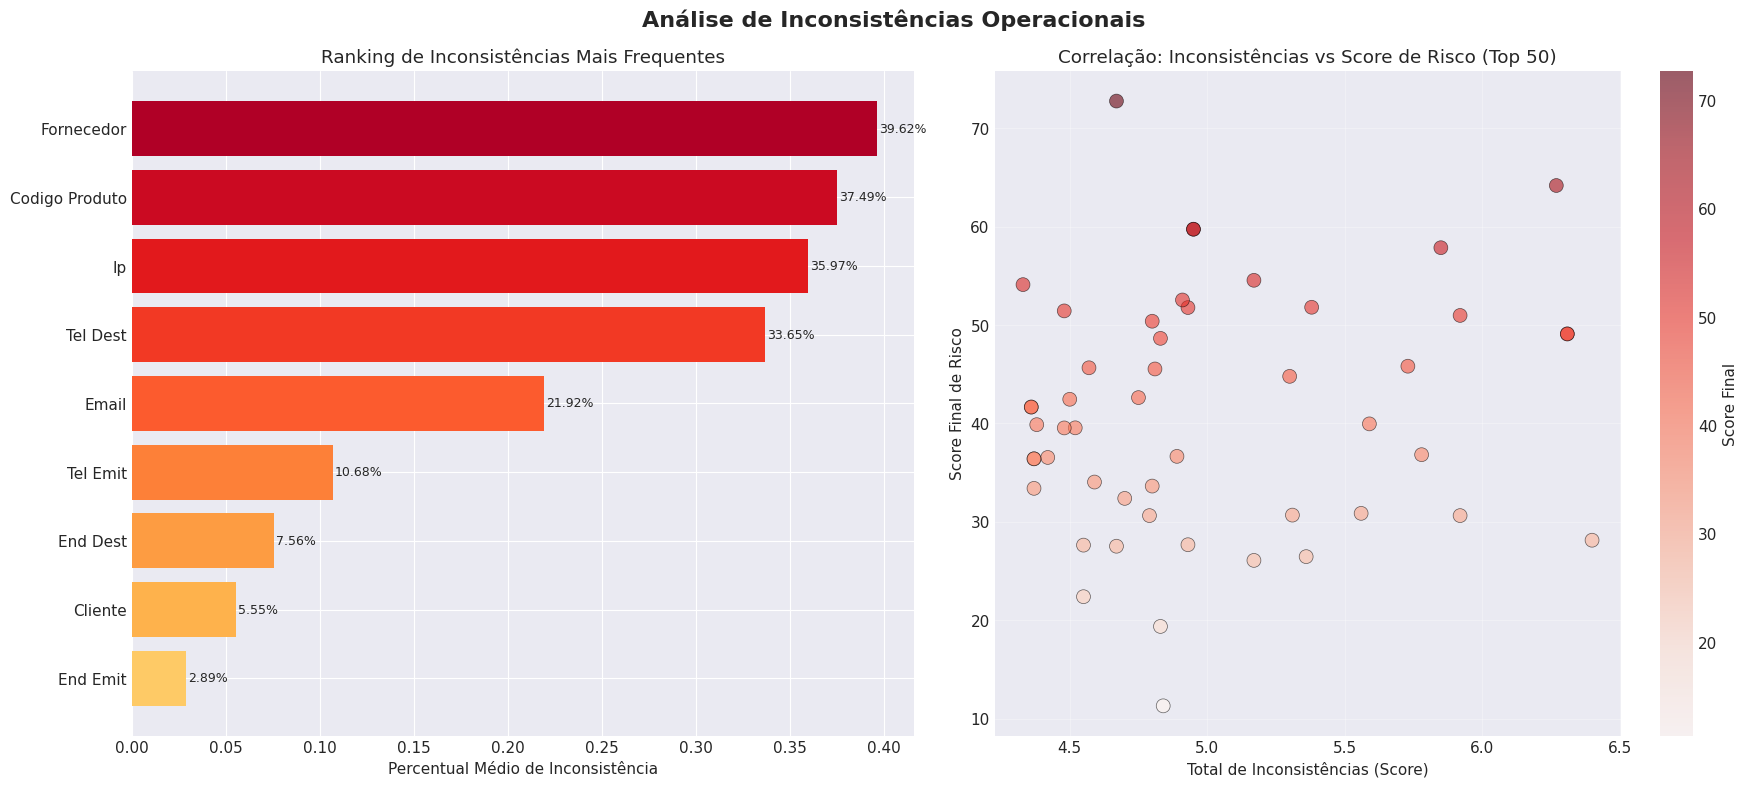

In [10]:
print("\n" + "=" * 80)
print("4. ANÁLISE DETALHADA DE INCONSISTÊNCIAS OPERACIONAIS")
print("=" * 80)

query_inconsistencias = """
SELECT 
    num_grupo,
    ROUND(COALESCE(perc_cliente, 0), 2) AS perc_cliente,
    ROUND(COALESCE(perc_fornecedor, 0), 2) AS perc_fornecedor,
    ROUND(COALESCE(perc_email, 0), 2) AS perc_email,
    ROUND(COALESCE(perc_tel_dest, 0), 2) AS perc_tel_dest,
    ROUND(COALESCE(perc_tel_emit, 0), 2) AS perc_tel_emit,
    ROUND(COALESCE(perc_codigo_produto, 0), 2) AS perc_codigo_produto,
    ROUND(COALESCE(perc_end_emit, 0), 2) AS perc_end_emit,
    ROUND(COALESCE(perc_end_dest, 0), 2) AS perc_end_dest,
    ROUND(COALESCE(perc_ip_transmissao, 0), 2) AS perc_ip,
    total AS total_inconsistencias,
    score_final_avancado
FROM gessimples.gei_percent
WHERE total > 0
ORDER BY total DESC
LIMIT 1000
"""

df_incons = spark.sql(query_inconsistencias).toPandas()

# Estatísticas agregadas
incons_stats = df_incons[['perc_cliente', 'perc_fornecedor', 'perc_email', 
                           'perc_tel_dest', 'perc_tel_emit', 'perc_codigo_produto',
                           'perc_end_emit', 'perc_end_dest', 'perc_ip']].mean()

print("\nPERCENTUAL MÉDIO DE INCONSISTÊNCIAS POR TIPO:\n")
for tipo, valor in incons_stats.sort_values(ascending=False).items():
    print(f"  {tipo.replace('perc_', '').replace('_', ' ').title()}: {valor:.2%}")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise de Inconsistências Operacionais', fontsize=16, fontweight='bold')

incons_stats_sorted = incons_stats.sort_values(ascending=True)
colors_bar = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(incons_stats_sorted)))
bars = ax1.barh(range(len(incons_stats_sorted)), incons_stats_sorted.values, color=colors_bar)
ax1.set_yticks(range(len(incons_stats_sorted)))
ax1.set_yticklabels([t.replace('perc_', '').replace('_', ' ').title() for t in incons_stats_sorted.index])
ax1.set_xlabel('Percentual Médio de Inconsistência')
ax1.set_title('Ranking de Inconsistências Mais Frequentes')

for i, (bar, value) in enumerate(zip(bars, incons_stats_sorted.values)):
    ax1.text(value + 0.001, i, f'{value:.2%}', va='center', fontsize=9)

# Correlação entre inconsistências e score final
top_incons = df_incons.nlargest(50, 'total_inconsistencias')
scatter = ax2.scatter(top_incons['total_inconsistencias'], 
                      top_incons['score_final_avancado'],
                      s=100, alpha=0.6, c=top_incons['score_final_avancado'],
                      cmap='Reds', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Total de Inconsistências (Score)')
ax2.set_ylabel('Score Final de Risco')
ax2.set_title('Correlação: Inconsistências vs Score de Risco (Top 50)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Score Final')

plt.tight_layout()
plt.show()


5. ANÁLISE DE CONFUSÃO PATRIMONIAL (Pagamentos)

TOP 10 GRUPOS COM MAIOR RISCO DE CONFUSÃO PATRIMONIAL:

 1. Grupo 1554
    Índice de Risco Pagamentos: 19.4894
    Pagamentos Empresas: R$ 36,400.00
    Pagamentos Sócios: R$ 709,415.36
    Sócios Compartilhados: 1

 2. Grupo 686
    Índice de Risco Pagamentos: 11.5522
    Pagamentos Empresas: R$ 38,935.39
    Pagamentos Sócios: R$ 449,788.32
    Sócios Compartilhados: 1

 3. Grupo 995
    Índice de Risco Pagamentos: 8.8887
    Pagamentos Empresas: R$ 376,699.02
    Pagamentos Sócios: R$ 3,348,346.61
    Sócios Compartilhados: 4

 4. Grupo 1038
    Índice de Risco Pagamentos: 4.5038
    Pagamentos Empresas: R$ 388,901.69
    Pagamentos Sócios: R$ 1,751,542.84
    Sócios Compartilhados: 1

 5. Grupo 1220
    Índice de Risco Pagamentos: 4.2166
    Pagamentos Empresas: R$ 851,469.03
    Pagamentos Sócios: R$ 3,590,319.41
    Sócios Compartilhados: 1

 6. Grupo 624
    Índice de Risco Pagamentos: 2.2005
    Pagamentos Empresas: R$ 773,841.1

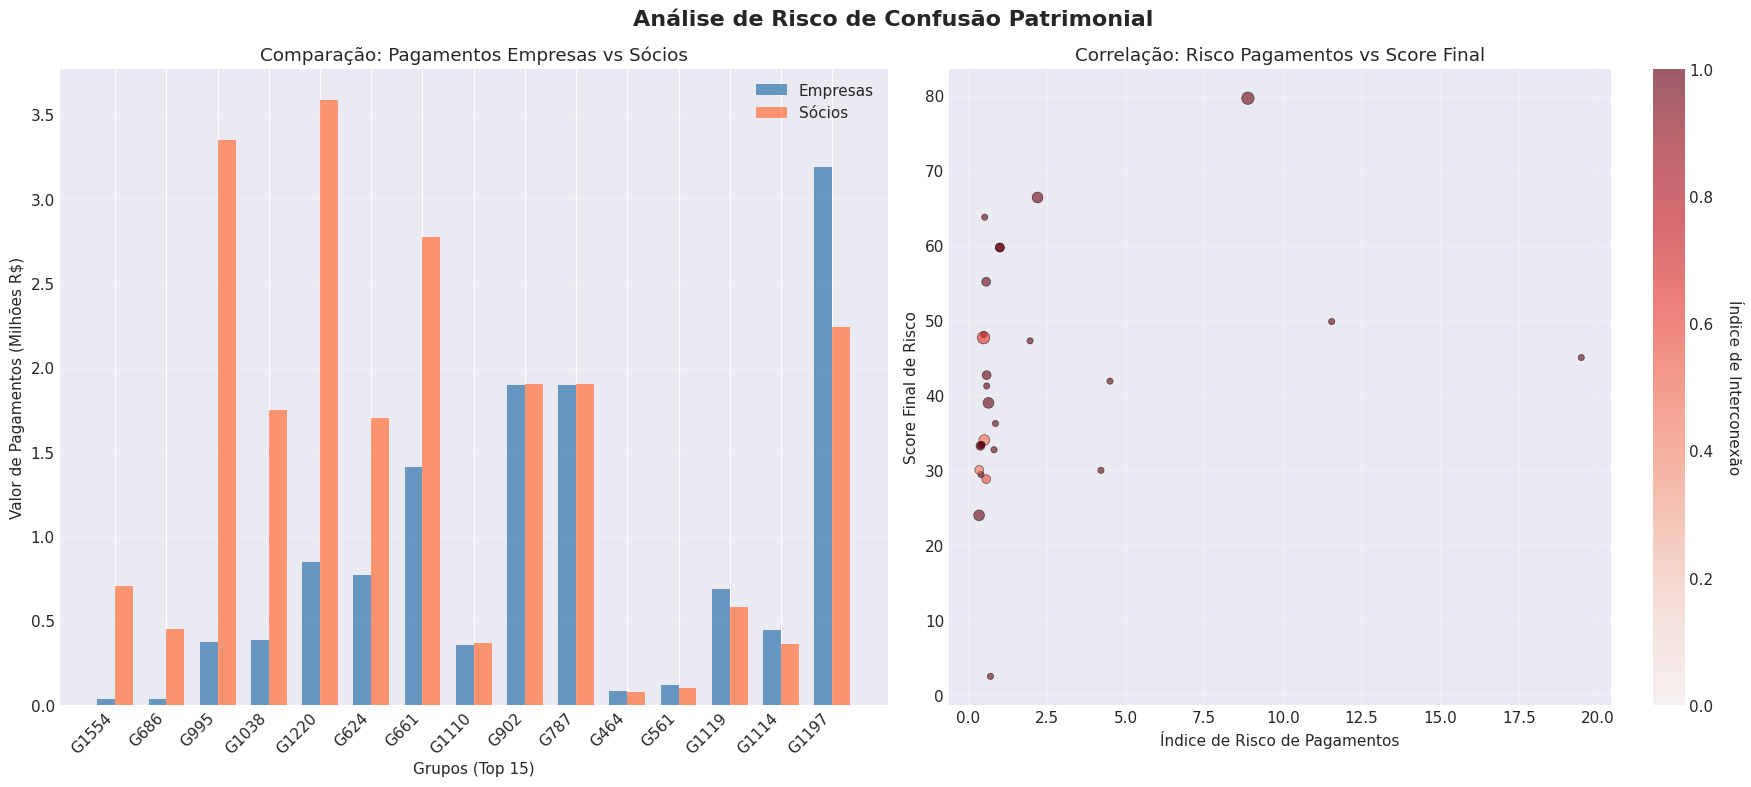

In [11]:
print("\n" + "=" * 80)
print("5. ANÁLISE DE CONFUSÃO PATRIMONIAL (Pagamentos)")
print("=" * 80)

query_pagamentos = """
SELECT 
    num_grupo,
    qntd_cnpj,
    valor_meios_pagamento_empresas,
    valor_meios_pagamento_socios,
    ROUND(indice_risco_pagamentos, 4) AS indice_risco_pagamentos,
    ROUND(indice_interconexao, 4) AS indice_interconexao,
    qtd_socios_compartilhados,
    score_final_avancado
FROM gessimples.gei_percent
WHERE valor_meios_pagamento_empresas > 0
ORDER BY indice_risco_pagamentos DESC
LIMIT 30
"""

df_pagamentos = spark.sql(query_pagamentos).toPandas()

# Conversão de Decimal para float
df_pagamentos['valor_meios_pagamento_empresas'] = df_pagamentos['valor_meios_pagamento_empresas'].astype(float)
df_pagamentos['valor_meios_pagamento_socios'] = df_pagamentos['valor_meios_pagamento_socios'].astype(float)

print("\nTOP 10 GRUPOS COM MAIOR RISCO DE CONFUSÃO PATRIMONIAL:\n")
for idx, row in df_pagamentos.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Índice de Risco Pagamentos: {row['indice_risco_pagamentos']:.4f}")
    print(f"    Pagamentos Empresas: R$ {row['valor_meios_pagamento_empresas']:,.2f}")
    print(f"    Pagamentos Sócios: R$ {row['valor_meios_pagamento_socios']:,.2f}")
    print(f"    Sócios Compartilhados: {int(row['qtd_socios_compartilhados'])}")
    print()

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise de Risco de Confusão Patrimonial', fontsize=16, fontweight='bold')

top15_pag = df_pagamentos.head(15)
x = np.arange(len(top15_pag))
width = 0.35

bars1 = ax1.bar(x - width/2, top15_pag['valor_meios_pagamento_empresas']/1e6, 
                width, label='Empresas', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, top15_pag['valor_meios_pagamento_socios']/1e6, 
                width, label='Sócios', color='coral', alpha=0.8)

ax1.set_xlabel('Grupos (Top 15)')
ax1.set_ylabel('Valor de Pagamentos (Milhões R$)')
ax1.set_title('Comparação: Pagamentos Empresas vs Sócios')
ax1.set_xticks(x)
ax1.set_xticklabels([f'G{int(g)}' for g in top15_pag['num_grupo']], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

scatter = ax2.scatter(df_pagamentos['indice_risco_pagamentos'], 
                      df_pagamentos['score_final_avancado'],
                      s=df_pagamentos['qtd_socios_compartilhados']*20,
                      alpha=0.6, c=df_pagamentos['indice_interconexao'],
                      cmap='Reds', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Índice de Risco de Pagamentos')
ax2.set_ylabel('Score Final de Risco')
ax2.set_title('Correlação: Risco Pagamentos vs Score Final')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Índice de Interconexão', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()


6. ANÁLISE TEMPORAL: EVOLUÇÃO DE RECEITAS E LIMITES SN

TOP 10 GRUPOS POR RECEITA MÁXIMA (12 MESES):

 1. Grupo 211
    Receita Máxima: R$ 10,350,377.95
    Período: mar2023
    Situação: Acima do Limite
    Score: 64.17

 2. Grupo 365
    Receita Máxima: R$ 9,972,289.60
    Período: set2024
    Situação: Acima do Limite
    Score: 27.64

 3. Grupo 889
    Receita Máxima: R$ 9,397,136.72
    Período: out2024
    Situação: Acima do Limite
    Score: 60.48

 4. Grupo 137
    Receita Máxima: R$ 8,646,976.61
    Período: dez2022
    Situação: Acima do Limite
    Score: 27.58

 5. Grupo 1279
    Receita Máxima: R$ 8,448,268.95
    Período: abr2022
    Situação: Acima do Limite
    Score: 59.43

 6. Grupo 122
    Receita Máxima: R$ 8,446,018.43
    Período: nov2021
    Situação: Acima do Limite
    Score: 35.90

 7. Grupo 1074
    Receita Máxima: R$ 8,186,248.88
    Período: fev2025
    Situação: Acima do Limite
    Score: 39.88

 8. Grupo 401
    Receita Máxima: R$ 7,965,520.14
    Período

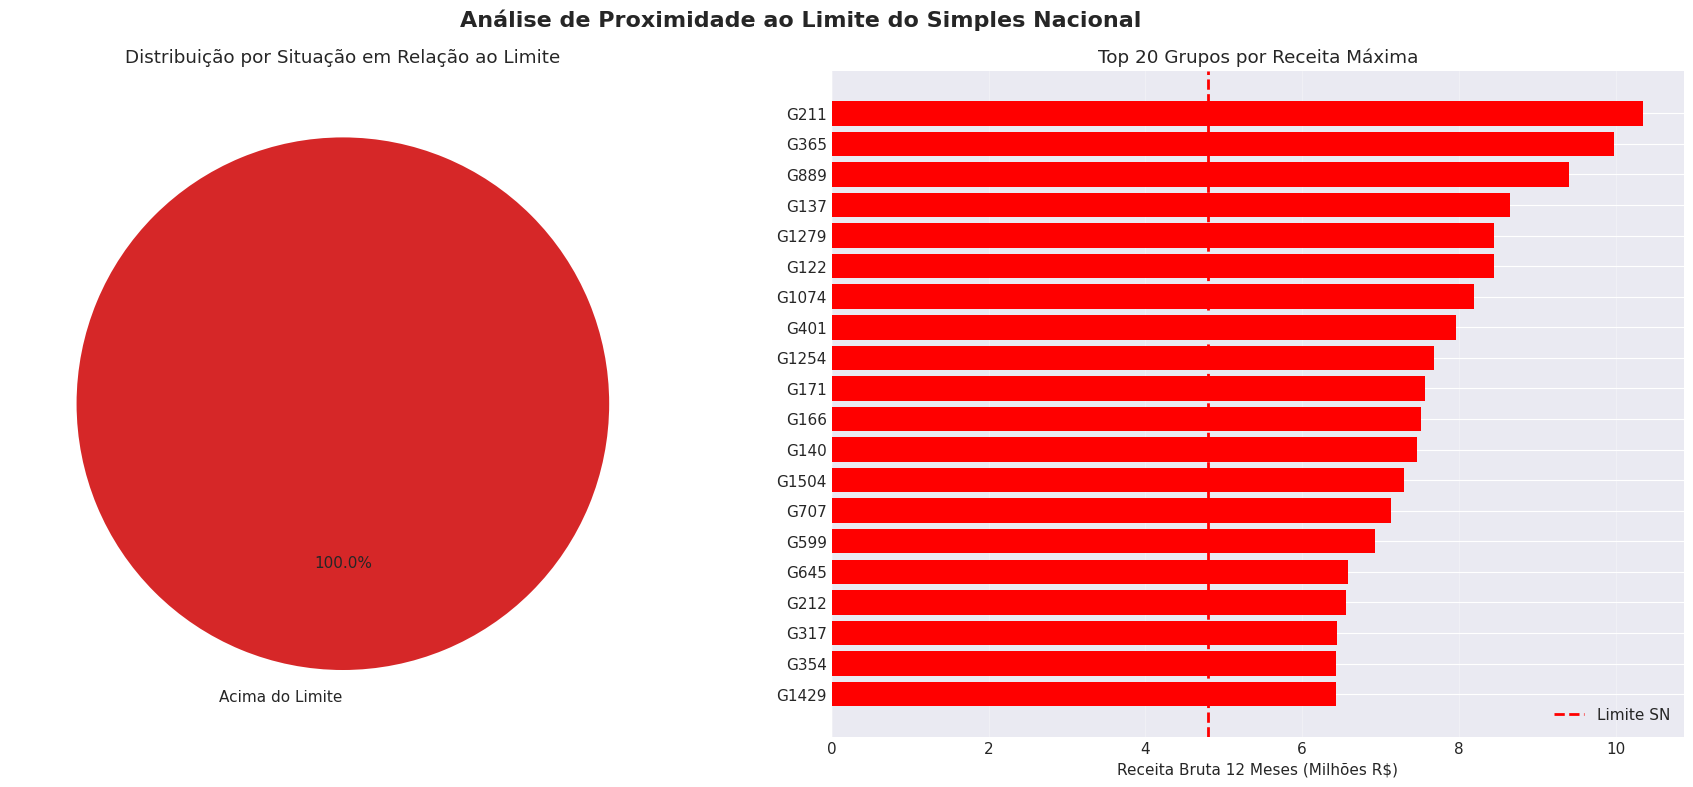

In [12]:
print("\n" + "=" * 80)
print("6. ANÁLISE TEMPORAL: EVOLUÇÃO DE RECEITAS E LIMITES SN")
print("=" * 80)

query_temporal = """
SELECT 
    num_grupo,
    valor_max AS receita_maxima,
    periodo_max,
    qntd_cnpj,
    score_final_avancado,
    CASE 
        WHEN valor_max >= 4800000 THEN 'Acima do Limite'
        WHEN valor_max >= 4300000 THEN 'Muito Próximo (90%+)'
        WHEN valor_max >= 3840000 THEN 'Próximo (80%+)'
        ELSE 'Dentro do Limite'
    END AS situacao_limite
FROM gessimples.gei_percent
WHERE valor_max > 0
ORDER BY valor_max DESC
LIMIT 30
"""

df_temporal = spark.sql(query_temporal).toPandas()
df_temporal['receita_maxima'] = df_temporal['receita_maxima'].astype(float)

print("\nTOP 10 GRUPOS POR RECEITA MÁXIMA (12 MESES):\n")
for idx, row in df_temporal.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Receita Máxima: R$ {row['receita_maxima']:,.2f}")
    print(f"    Período: {row['periodo_max']}")
    print(f"    Situação: {row['situacao_limite']}")
    print(f"    Score: {row['score_final_avancado']:.2f}")
    print()

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise de Proximidade ao Limite do Simples Nacional', fontsize=16, fontweight='bold')

situacao_counts = df_temporal['situacao_limite'].value_counts()
colors_pie = ['#d62728', '#ff7f0e', '#ffdd70', '#2ca02c']
ax1.pie(situacao_counts.values, labels=situacao_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax1.set_title('Distribuição por Situação em Relação ao Limite')

# Linha de limite do SN
limite_sn = 4_800_000
top20_temp = df_temporal.head(20).sort_values('receita_maxima', ascending=True)

bars = ax2.barh(range(len(top20_temp)), top20_temp['receita_maxima']/1e6,
                color=['red' if v >= limite_sn else 'orange' if v >= limite_sn*0.9 
                       else 'yellow' if v >= limite_sn*0.8 else 'green' 
                       for v in top20_temp['receita_maxima']])
ax2.axvline(x=limite_sn/1e6, color='red', linestyle='--', linewidth=2, label='Limite SN')
ax2.set_yticks(range(len(top20_temp)))
ax2.set_yticklabels([f'G{int(g)}' for g in top20_temp['num_grupo']])
ax2.set_xlabel('Receita Bruta 12 Meses (Milhões R$)')
ax2.set_title('Top 20 Grupos por Receita Máxima')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


7. ANÁLISE SETORIAL POR CNAE

TOP 10 SETORES POR SCORE MÉDIO DE RISCO:

 1. Seção 22 (CNAE 22)
    Grupos: 9 | Score Médio: 47.79
    Range: 35.90 - 66.58
    Receita Média: R$ 6,292,036.67
    Grupos Alto Risco: 9

 2. Seção 14 (CNAE 14)
    Grupos: 13 | Score Médio: 47.30
    Range: 35.45 - 70.67
    Receita Média: R$ 1,738,543.19
    Grupos Alto Risco: 13

 3. Seção 43 (CNAE 43)
    Grupos: 8 | Score Médio: 46.10
    Range: 29.81 - 66.42
    Receita Média: R$ nan
    Grupos Alto Risco: 8

 4. Seção 13 (CNAE 13)
    Grupos: 5 | Score Médio: 45.19
    Range: 21.71 - 71.81
    Receita Média: R$ nan
    Grupos Alto Risco: 5

 5. Seção 16 (CNAE 16)
    Grupos: 11 | Score Médio: 44.34
    Range: 12.40 - 62.54
    Receita Média: R$ 5,648,006.22
    Grupos Alto Risco: 10

 6. Seção 49 (CNAE 49)
    Grupos: 5 | Score Médio: 43.53
    Range: 19.51 - 65.24
    Receita Média: R$ nan
    Grupos Alto Risco: 5

 7. Seção 25 (CNAE 25)
    Grupos: 18 | Score Médio: 43.27
    Range: 5.40 - 79.66
   

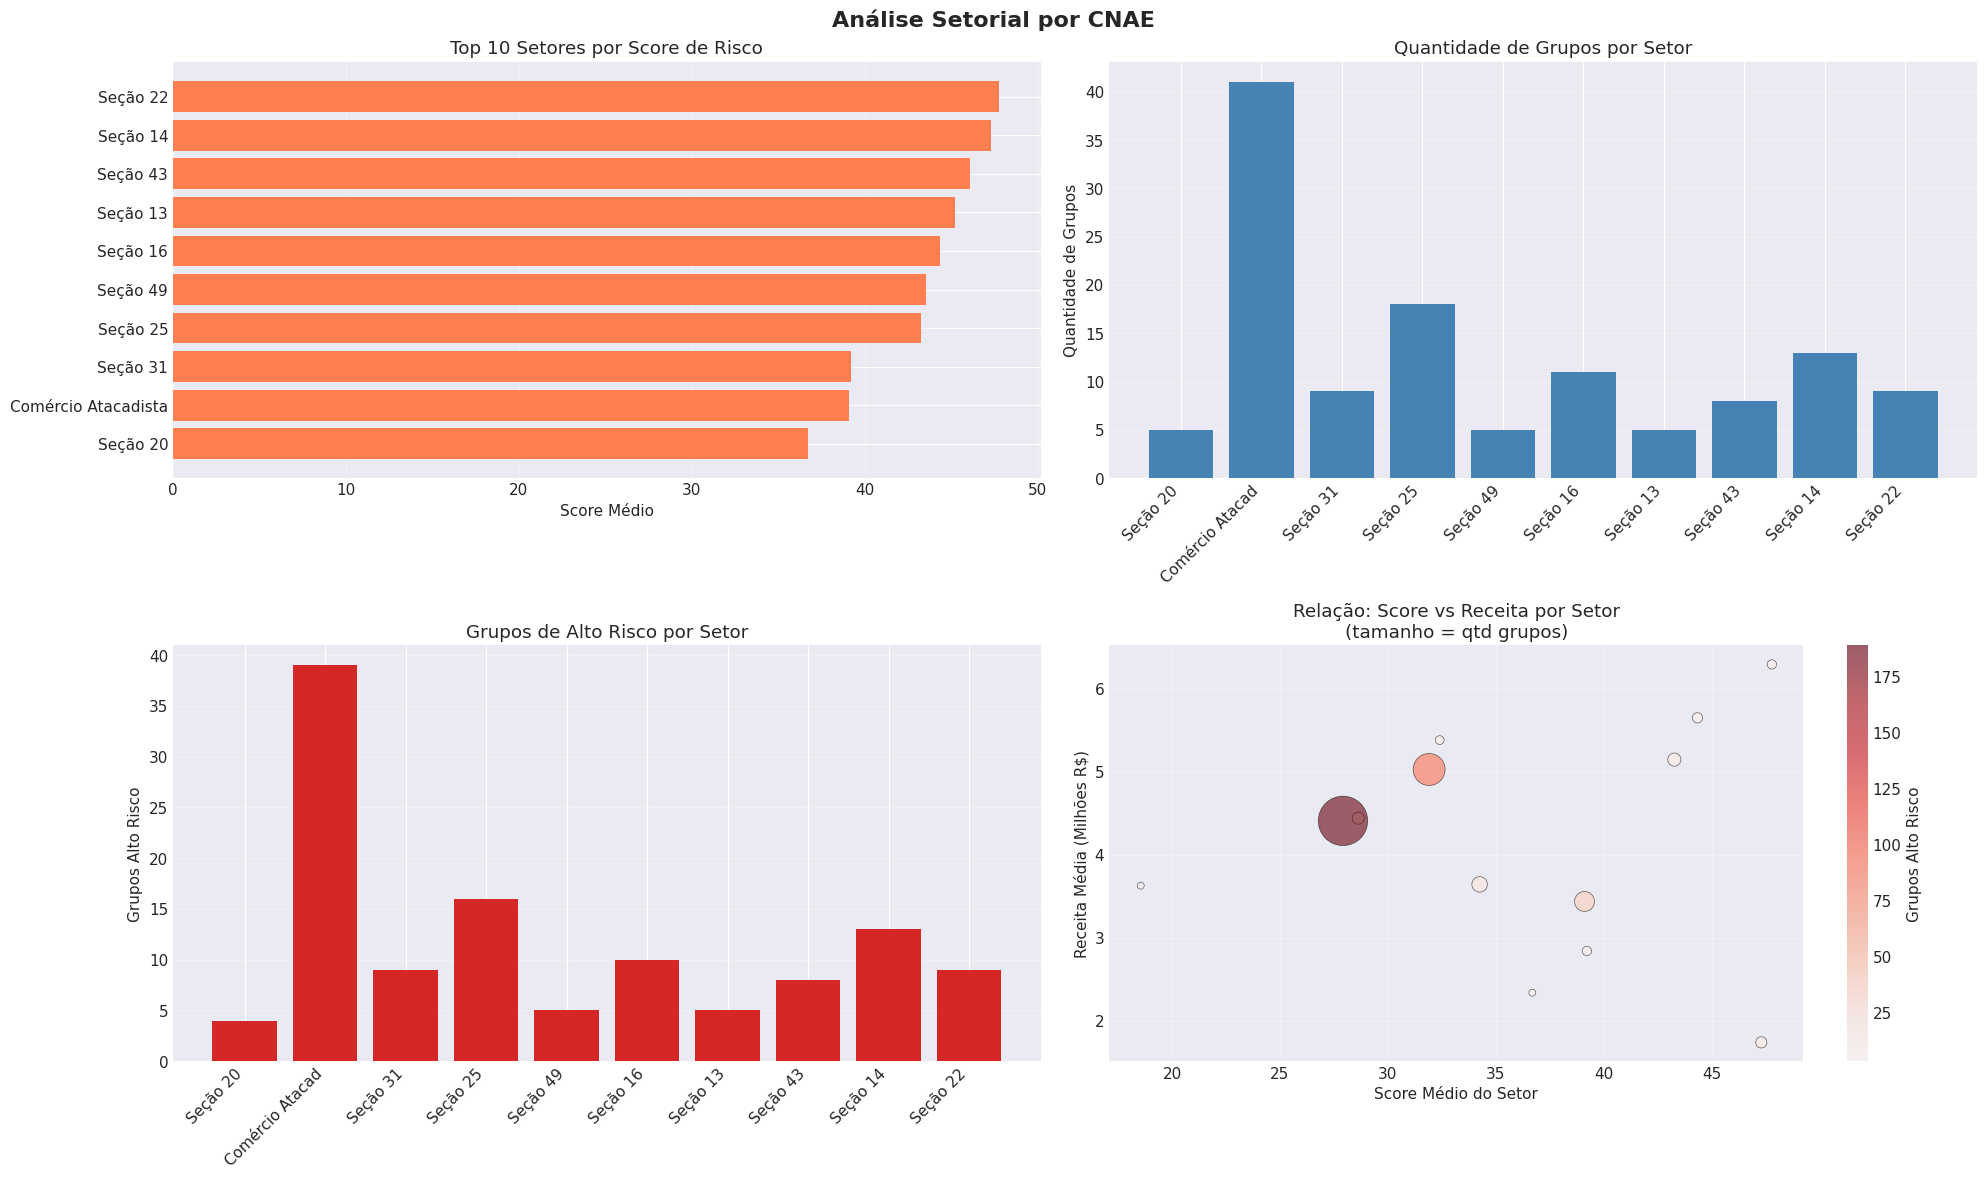

In [13]:
print("\n" + "=" * 80)
print("7. ANÁLISE SETORIAL POR CNAE")
print("=" * 80)

query_setorial = """
WITH cnae_grupos AS (
    SELECT
        g.num_grupo,
        c.cd_cnae,
        SUBSTR(CAST(c.cd_cnae AS STRING), 1, 2) AS secao_cnae
    FROM gessimples.gei_cnpj g
    JOIN gessimples.gei_cadastro c ON g.cnpj = c.nu_cnpj
    WHERE c.cd_cnae IS NOT NULL
),
grupos_cnae_principal AS (
    SELECT
        num_grupo,
        secao_cnae,
        ROW_NUMBER() OVER (PARTITION BY num_grupo ORDER BY secao_cnae) AS rn
    FROM cnae_grupos
    GROUP BY num_grupo, secao_cnae
)
SELECT 
    gcp.secao_cnae,
    CASE 
        WHEN gcp.secao_cnae = '01' THEN 'Agricultura, Pecuária'
        WHEN gcp.secao_cnae = '10' THEN 'Fabricação de Alimentos'
        WHEN gcp.secao_cnae = '46' THEN 'Comércio Atacadista'
        WHEN gcp.secao_cnae = '47' THEN 'Comércio Varejista'
        WHEN gcp.secao_cnae = '68' THEN 'Atividades Imobiliárias'
        WHEN gcp.secao_cnae = '70' THEN 'Consultoria'
        WHEN gcp.secao_cnae = '77' THEN 'Aluguel e Leasing'
        WHEN gcp.secao_cnae = '82' THEN 'Serviços de Apoio'
        ELSE CONCAT('Seção ', gcp.secao_cnae)
    END as descricao_setor,
    COUNT(DISTINCT gcp.num_grupo) as grupos_no_setor,
    ROUND(AVG(p.score_final_avancado), 2) as score_medio_setor,
    ROUND(MIN(p.score_final_avancado), 2) as score_minimo_setor,
    ROUND(MAX(p.score_final_avancado), 2) as score_maximo_setor,
    ROUND(AVG(p.valor_max), 2) as receita_media_setor,
    COUNT(CASE WHEN p.score_final_avancado >= 15 THEN 1 END) as grupos_alto_risco
FROM grupos_cnae_principal gcp
JOIN gessimples.gei_percent p ON gcp.num_grupo = p.num_grupo
WHERE gcp.rn = 1
GROUP BY gcp.secao_cnae
HAVING COUNT(DISTINCT gcp.num_grupo) >= 5
ORDER BY score_medio_setor DESC
LIMIT 20
"""

df_setorial = spark.sql(query_setorial).toPandas()
df_setorial['receita_media_setor'] = pd.to_numeric(df_setorial['receita_media_setor'], errors='coerce')
df_setorial['score_medio_setor'] = pd.to_numeric(df_setorial['score_medio_setor'], errors='coerce')

print("\nTOP 10 SETORES POR SCORE MÉDIO DE RISCO:\n")
for idx, row in df_setorial.head(10).iterrows():
    print(f"{idx+1:2d}. {row['descricao_setor']} (CNAE {row['secao_cnae']})")
    print(f"    Grupos: {int(row['grupos_no_setor'])} | Score Médio: {row['score_medio_setor']:.2f}")
    print(f"    Range: {row['score_minimo_setor']:.2f} - {row['score_maximo_setor']:.2f}")
    print(f"    Receita Média: R$ {row['receita_media_setor']:,.2f}")
    print(f"    Grupos Alto Risco: {int(row['grupos_alto_risco'])}")
    print()

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análise Setorial por CNAE', fontsize=16, fontweight='bold')

# Score médio por setor
top10_set = df_setorial.head(10).sort_values('score_medio_setor', ascending=True)
axes[0,0].barh(top10_set['descricao_setor'], top10_set['score_medio_setor'], color='coral')
axes[0,0].set_xlabel('Score Médio')
axes[0,0].set_title('Top 10 Setores por Score de Risco')
axes[0,0].grid(True, alpha=0.3, axis='x')

# Grupos por setor
axes[0,1].bar(range(len(top10_set)), top10_set['grupos_no_setor'], color='steelblue')
axes[0,1].set_xticks(range(len(top10_set)))
axes[0,1].set_xticklabels([x[:15] for x in top10_set['descricao_setor']], rotation=45, ha='right')
axes[0,1].set_ylabel('Quantidade de Grupos')
axes[0,1].set_title('Quantidade de Grupos por Setor')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Grupos alto risco
axes[1,0].bar(range(len(top10_set)), top10_set['grupos_alto_risco'], color='#d62728')
axes[1,0].set_xticks(range(len(top10_set)))
axes[1,0].set_xticklabels([x[:15] for x in top10_set['descricao_setor']], rotation=45, ha='right')
axes[1,0].set_ylabel('Grupos Alto Risco')
axes[1,0].set_title('Grupos de Alto Risco por Setor')
axes[1,0].grid(True, alpha=0.3, axis='y')

# Scatter: Score vs Receita (com tratamento de dados)
df_plot = df_setorial.dropna(subset=['score_medio_setor', 'receita_media_setor'])
scatter = axes[1,1].scatter(df_plot['score_medio_setor'], 
                            df_plot['receita_media_setor']/1e6,
                            s=df_plot['grupos_no_setor']*5, 
                            alpha=0.6, 
                            c=df_plot['grupos_alto_risco'],
                            cmap='Reds', 
                            edgecolors='black', 
                            linewidth=0.5)
axes[1,1].set_xlabel('Score Médio do Setor')
axes[1,1].set_ylabel('Receita Média (Milhões R$)')
axes[1,1].set_title('Relação: Score vs Receita por Setor\n(tamanho = qtd grupos)')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,1], label='Grupos Alto Risco')

plt.tight_layout()
plt.show()

2025-10-09T18:37:52.694740Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-09T18:37:52.696014Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224



8. ANÁLISE DE INDÍCIOS FISCAIS

TOP 10 GRUPOS COM MAIS INDÍCIOS FISCAIS:

 1. Grupo 688
    Total de Indícios: 63
    Tipos Distintos: 16
    CNPJs com Indícios: 8/8
    Score: 52.05

 2. Grupo 401
    Total de Indícios: 59
    Tipos Distintos: 23
    CNPJs com Indícios: 4/5
    Score: 57.98

 3. Grupo 1067
    Total de Indícios: 56
    Tipos Distintos: 20
    CNPJs com Indícios: 7/7
    Score: 63.79

 4. Grupo 212
    Total de Indícios: 56
    Tipos Distintos: 17
    CNPJs com Indícios: 6/6
    Score: 54.31

 5. Grupo 156
    Total de Indícios: 55
    Tipos Distintos: 17
    CNPJs com Indícios: 5/6
    Score: 47.71

 6. Grupo 841
    Total de Indícios: 54
    Tipos Distintos: 18
    CNPJs com Indícios: 5/6
    Score: 47.80

 7. Grupo 889
    Total de Indícios: 51
    Tipos Distintos: 18
    CNPJs com Indícios: 5/5
    Score: 60.48

 8. Grupo 783
    Total de Indícios: 50
    Tipos Distintos: 20
    CNPJs com Indícios: 5/5
    Score: 63.40

 9. Grupo 125
    Total de Indícios: 48
    

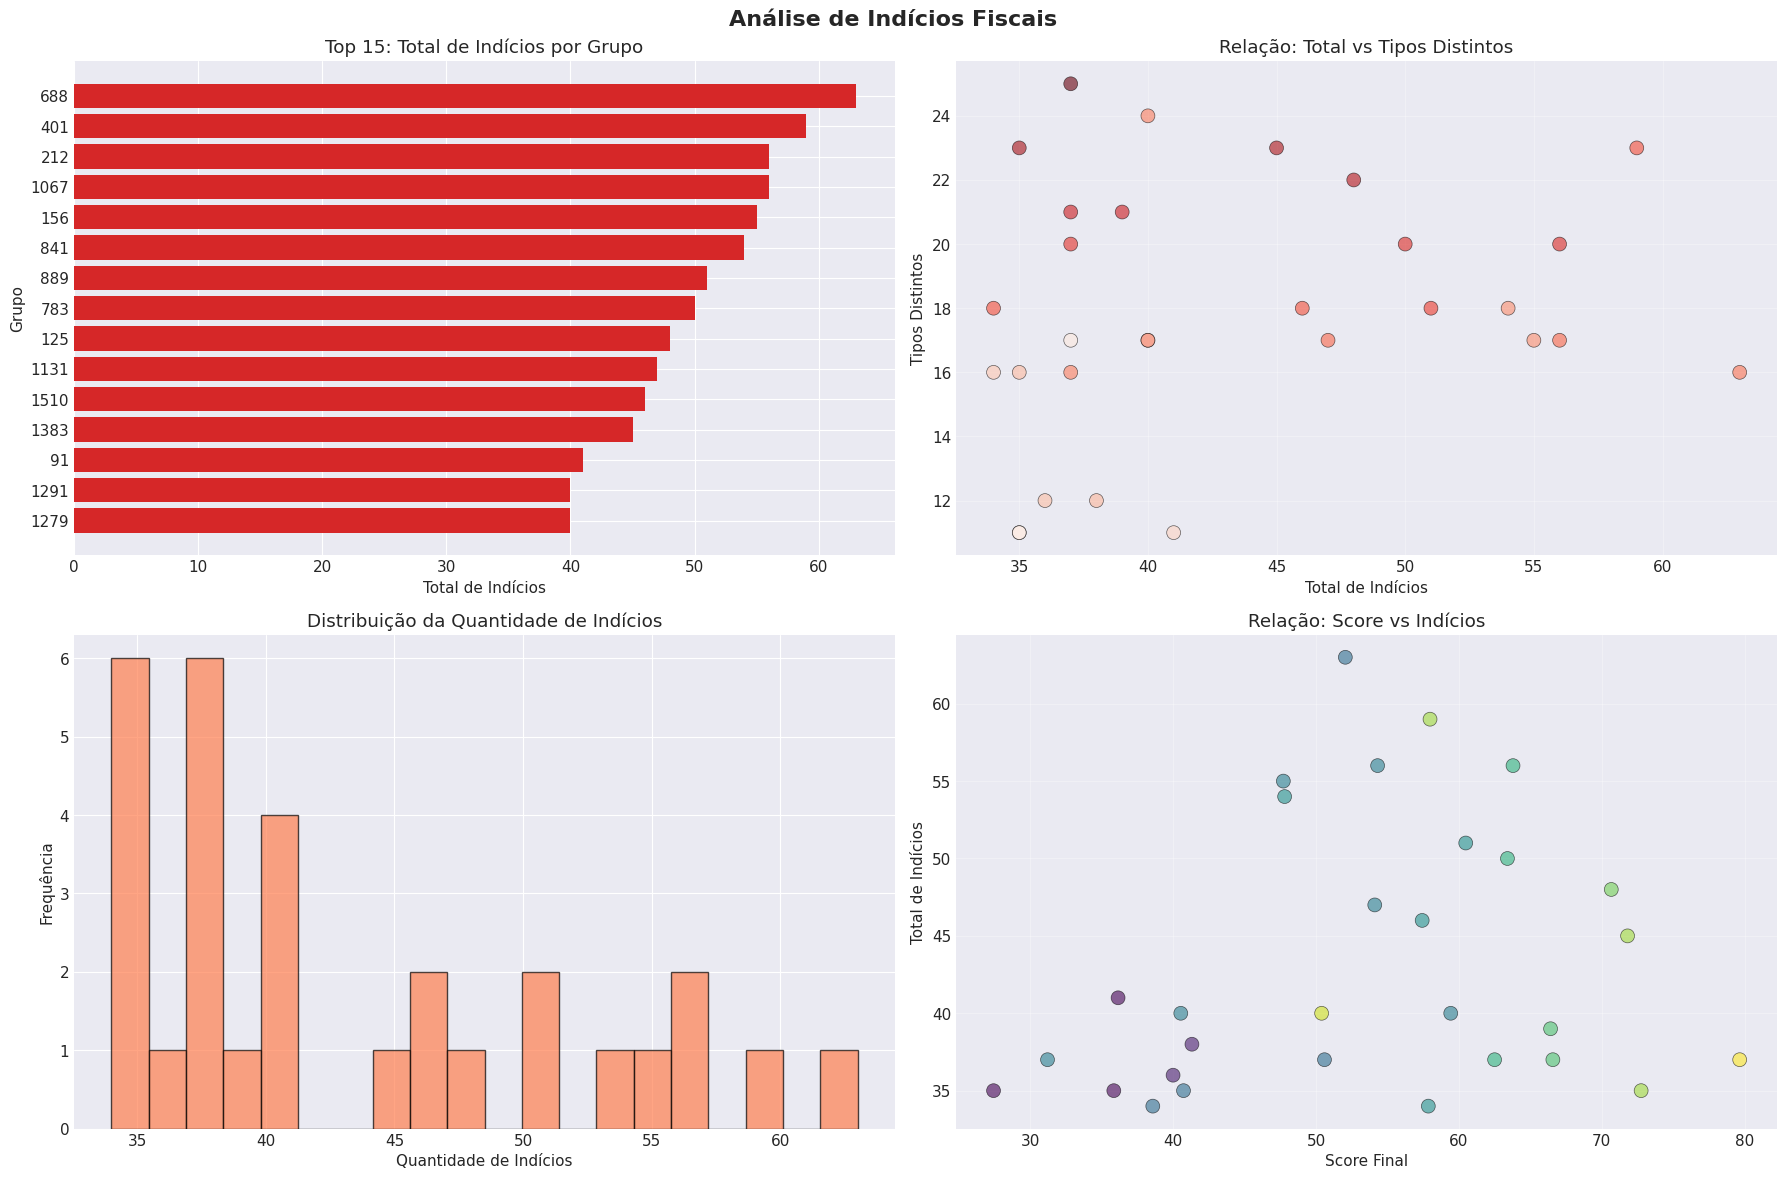

In [14]:
print("\n" + "=" * 80)
print("8. ANÁLISE DE INDÍCIOS FISCAIS")
print("=" * 80)

query_indicios = """
SELECT 
    p.num_grupo,
    p.qtd_total_indicios,
    p.qtd_tipos_indicios_distintos,
    p.qtd_cnpjs_com_indicios,
    p.qntd_cnpj,
    p.score_final_avancado,
    p.nivel_risco_grupo_economico
FROM gessimples.gei_percent p
WHERE p.qtd_total_indicios > 0
ORDER BY p.qtd_total_indicios DESC, p.score_final_avancado DESC
LIMIT 30
"""

df_indicios = spark.sql(query_indicios).toPandas()
df_indicios['score_final_avancado'] = pd.to_numeric(df_indicios['score_final_avancado'], errors='coerce')

print("\nTOP 10 GRUPOS COM MAIS INDÍCIOS FISCAIS:\n")
for idx, row in df_indicios.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Total de Indícios: {int(row['qtd_total_indicios'])}")
    print(f"    Tipos Distintos: {int(row['qtd_tipos_indicios_distintos'])}")
    print(f"    CNPJs com Indícios: {int(row['qtd_cnpjs_com_indicios'])}/{int(row['qntd_cnpj'])}")
    print(f"    Score: {row['score_final_avancado']:.2f}")
    print()

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Análise de Indícios Fiscais', fontsize=16, fontweight='bold')

# Total de indícios
top15_ind = df_indicios.head(15).sort_values('qtd_total_indicios', ascending=True)
axes[0,0].barh(top15_ind['num_grupo'].astype(str), top15_ind['qtd_total_indicios'], color='#d62728')
axes[0,0].set_xlabel('Total de Indícios')
axes[0,0].set_ylabel('Grupo')
axes[0,0].set_title('Top 15: Total de Indícios por Grupo')

# Tipos distintos
axes[0,1].scatter(df_indicios['qtd_total_indicios'], df_indicios['qtd_tipos_indicios_distintos'],
                  s=100, alpha=0.6, c=df_indicios['score_final_avancado'], cmap='Reds',
                  edgecolors='black', linewidth=0.5)
axes[0,1].set_xlabel('Total de Indícios')
axes[0,1].set_ylabel('Tipos Distintos')
axes[0,1].set_title('Relação: Total vs Tipos Distintos')
axes[0,1].grid(True, alpha=0.3)

# Distribuição de indícios
axes[1,0].hist(df_indicios['qtd_total_indicios'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1,0].set_xlabel('Quantidade de Indícios')
axes[1,0].set_ylabel('Frequência')
axes[1,0].set_title('Distribuição da Quantidade de Indícios')

# Score vs Indícios
axes[1,1].scatter(df_indicios['score_final_avancado'], df_indicios['qtd_total_indicios'],
                  s=100, alpha=0.6, c=df_indicios['qtd_tipos_indicios_distintos'], cmap='viridis',
                  edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('Score Final')
axes[1,1].set_ylabel('Total de Indícios')
axes[1,1].set_title('Relação: Score vs Indícios')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


9. ANÁLISE DE ESTRUTURA SOCIETÁRIA E INTERCONEXÃO

TOP 10 GRUPOS POR ÍNDICE DE INTERCONEXÃO:

 1. Grupo 995
    CNPJs no Grupo: 2
    Sócios Compartilhados: 4
    CNPJs com Sócios Compartilhados: 2 (100.0%)
    Índice de Interconexão: 1.0000
    Score Final: 79.66

 2. Grupo 1344
    CNPJs no Grupo: 2
    Sócios Compartilhados: 2
    CNPJs com Sócios Compartilhados: 2 (100.0%)
    Índice de Interconexão: 1.0000
    Score Final: 72.76

 3. Grupo 1383
    CNPJs no Grupo: 3
    Sócios Compartilhados: 2
    CNPJs com Sócios Compartilhados: 3 (100.0%)
    Índice de Interconexão: 1.0000
    Score Final: 71.81

 4. Grupo 125
    CNPJs no Grupo: 6
    Sócios Compartilhados: 2
    CNPJs com Sócios Compartilhados: 6 (100.0%)
    Índice de Interconexão: 1.0000
    Score Final: 70.67

 5. Grupo 5
    CNPJs no Grupo: 2
    Sócios Compartilhados: 2
    CNPJs com Sócios Compartilhados: 2 (100.0%)
    Índice de Interconexão: 1.0000
    Score Final: 66.58

 6. Grupo 624
    CNPJs no Grupo: 4
    Sócio

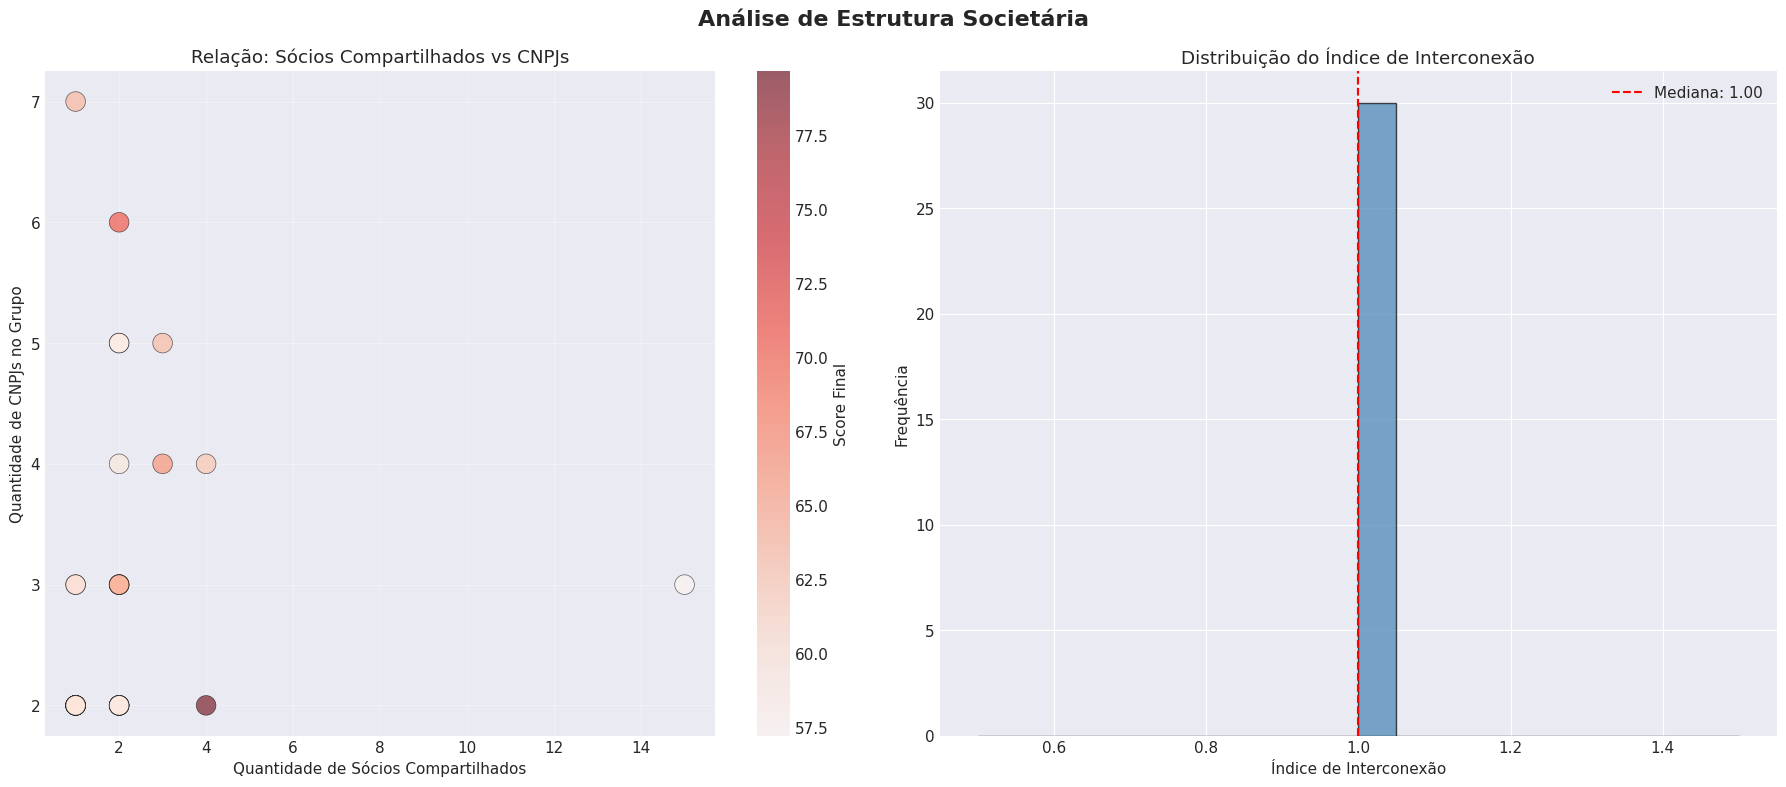

In [15]:
print("\n" + "=" * 80)
print("9. ANÁLISE DE ESTRUTURA SOCIETÁRIA E INTERCONEXÃO")
print("=" * 80)

query_societaria = """
SELECT 
    num_grupo,
    qntd_cnpj,
    qtd_socios_compartilhados,
    qtd_cnpjs_com_socios_compartilhados,
    indice_interconexao,
    score_final_avancado
FROM gessimples.gei_percent
WHERE qtd_socios_compartilhados > 0
ORDER BY indice_interconexao DESC, score_final_avancado DESC
LIMIT 30
"""

df_societaria = spark.sql(query_societaria).toPandas()
df_societaria['indice_interconexao'] = pd.to_numeric(df_societaria['indice_interconexao'], errors='coerce')
df_societaria['score_final_avancado'] = pd.to_numeric(df_societaria['score_final_avancado'], errors='coerce')

# Remover NaN
df_societaria = df_societaria.dropna(subset=['indice_interconexao', 'score_final_avancado'])

print("\nTOP 10 GRUPOS POR ÍNDICE DE INTERCONEXÃO:\n")
for idx, row in df_societaria.head(10).iterrows():
    perc_cnpjs_compartilhados = (row['qtd_cnpjs_com_socios_compartilhados'] / row['qntd_cnpj'] * 100)
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    CNPJs no Grupo: {int(row['qntd_cnpj'])}")
    print(f"    Sócios Compartilhados: {int(row['qtd_socios_compartilhados'])}")
    print(f"    CNPJs com Sócios Compartilhados: {int(row['qtd_cnpjs_com_socios_compartilhados'])} ({perc_cnpjs_compartilhados:.1f}%)")
    print(f"    Índice de Interconexão: {row['indice_interconexao']:.4f}")
    print(f"    Score Final: {row['score_final_avancado']:.2f}")
    print()

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise de Estrutura Societária', fontsize=16, fontweight='bold')

# Scatter 1 - Ajustado para evitar erro de tamanho
valid_data = df_societaria[df_societaria['indice_interconexao'].notna()]
scatter1 = ax1.scatter(valid_data['qtd_socios_compartilhados'], 
                       valid_data['qntd_cnpj'],
                       s=200,  # Tamanho fixo para evitar erro
                       alpha=0.6, 
                       c=valid_data['score_final_avancado'],
                       cmap='Reds', 
                       edgecolors='black', 
                       linewidth=0.5)
ax1.set_xlabel('Quantidade de Sócios Compartilhados')
ax1.set_ylabel('Quantidade de CNPJs no Grupo')
ax1.set_title('Relação: Sócios Compartilhados vs CNPJs')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Score Final')

# Histograma do índice
ax2.hist(valid_data['indice_interconexao'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Índice de Interconexão')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição do Índice de Interconexão')
ax2.axvline(valid_data['indice_interconexao'].median(), color='red', linestyle='--', 
            label=f'Mediana: {valid_data["indice_interconexao"].median():.2f}')
ax2.legend()

plt.tight_layout()
plt.show()


10. ANÁLISE C115 - RISCO DE GRUPO ECONÔMICO

TOP 10 GRUPOS COM MAIOR RISCO C115 (Grupo Econômico):

 1. Grupo 1292 - Nível: CRÍTICO
    Ranking Risco: 1 | Índice C115: 150.0000
    Tomadores: 2 | Com Compartilhamento: 2 (100.0%)
    CNPJs Relacionados: 2 | Tipos Comuns: 3
    Score Final: 56.71

 2. Grupo 105 - Nível: ALTO
    Ranking Risco: 2 | Índice C115: 100.0000
    Tomadores: 2 | Com Compartilhamento: 2 (100.0%)
    CNPJs Relacionados: 2 | Tipos Comuns: 2
    Score Final: 47.12

 3. Grupo 1054 - Nível: ALTO
    Ranking Risco: 2 | Índice C115: 100.0000
    Tomadores: 2 | Com Compartilhamento: 2 (100.0%)
    CNPJs Relacionados: 2 | Tipos Comuns: 2
    Score Final: 36.70

 4. Grupo 1097 - Nível: ALTO
    Ranking Risco: 2 | Índice C115: 100.0000
    Tomadores: 2 | Com Compartilhamento: 2 (100.0%)
    CNPJs Relacionados: 2 | Tipos Comuns: 2
    Score Final: 51.71

 5. Grupo 1199 - Nível: ALTO
    Ranking Risco: 2 | Índice C115: 100.0000
    Tomadores: 2 | Com Compartilhamento: 2 (100

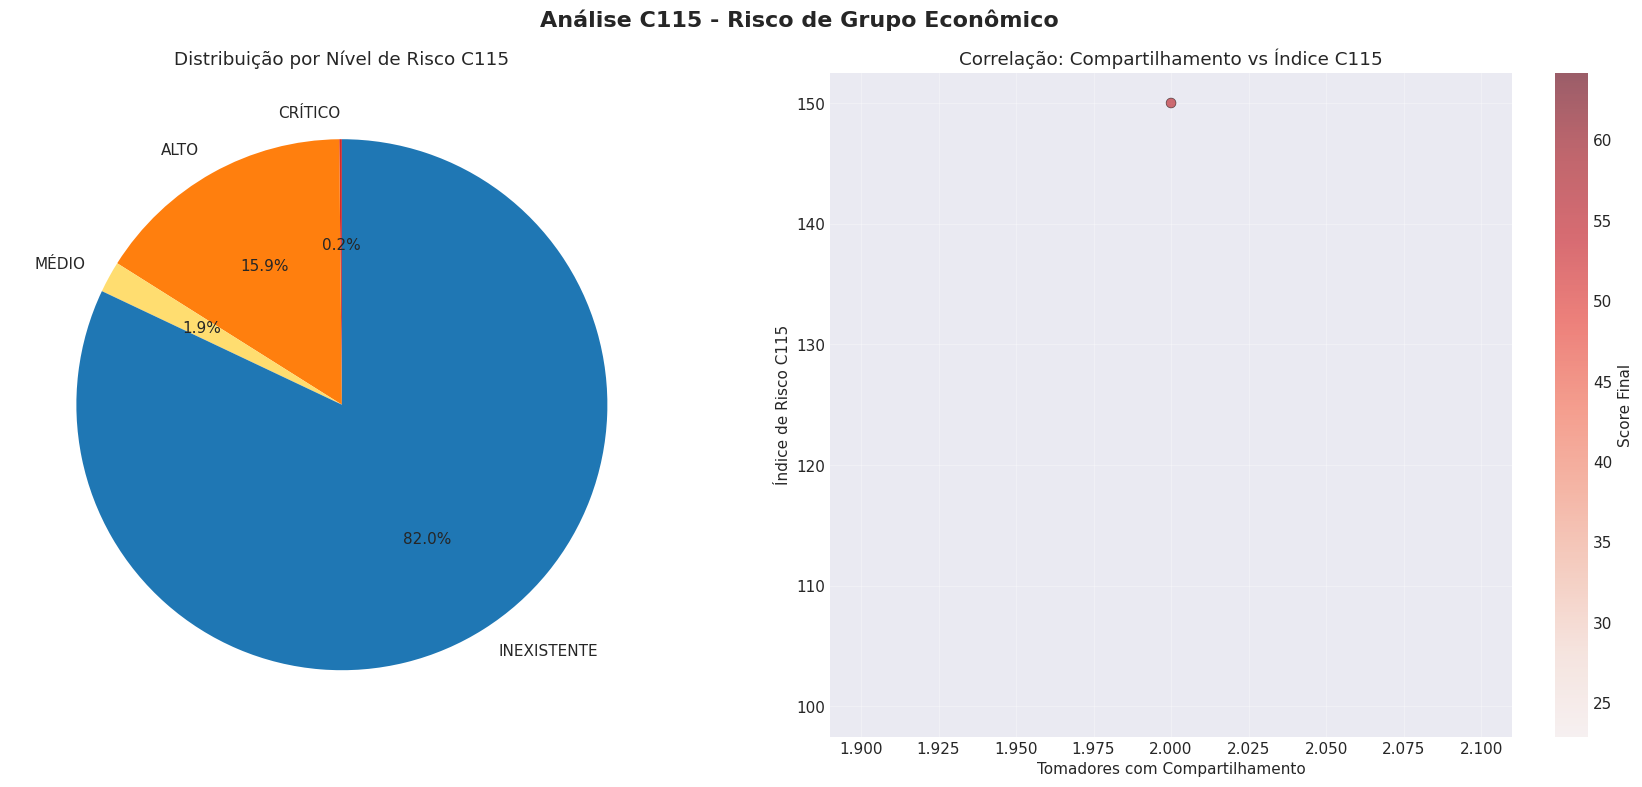

In [16]:
print("\n" + "=" * 80)
print("10. ANÁLISE C115 - RISCO DE GRUPO ECONÔMICO")
print("=" * 80)

query_c115 = """
SELECT 
    p.num_grupo,
    p.qntd_cnpj,
    r.nivel_risco_grupo_economico,
    r.ranking_risco,
    ROUND(r.indice_risco_grupo_economico, 4) AS indice_risco_c115,
    r.total_tomadores,
    r.tomadores_com_compartilhamento,
    ROUND(r.perc_tomadores_com_compartilhamento, 2) AS perc_tomadores_compartilhamento,
    r.qtd_cnpjs_relacionados,
    r.max_tipos_identificadores_comuns,
    r.pares_com_tres_tipos_comum,
    p.score_final_avancado
FROM gessimples.gei_c115_ranking_risco_grupo_economico r
JOIN gessimples.gei_percent p ON r.num_grupo = p.num_grupo
WHERE r.nivel_risco_grupo_economico IN ('CRÍTICO', 'ALTO', 'MÉDIO')
ORDER BY r.indice_risco_grupo_economico DESC
LIMIT 30
"""

df_c115 = spark.sql(query_c115).toPandas()

print("\nTOP 10 GRUPOS COM MAIOR RISCO C115 (Grupo Econômico):\n")
for idx, row in df_c115.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']} - Nível: {row['nivel_risco_grupo_economico']}")
    print(f"    Ranking Risco: {int(row['ranking_risco'])} | Índice C115: {row['indice_risco_c115']:.4f}")
    print(f"    Tomadores: {int(row['total_tomadores'])} | Com Compartilhamento: {int(row['tomadores_com_compartilhamento'])} ({row['perc_tomadores_compartilhamento']:.1f}%)")
    print(f"    CNPJs Relacionados: {int(row['qtd_cnpjs_relacionados'])} | Tipos Comuns: {int(row['max_tipos_identificadores_comuns'])}")
    print(f"    Score Final: {row['score_final_avancado']:.2f}")
    print()

# Distribuição por nível de risco C115
dist_c115 = spark.sql("""
SELECT 
    nivel_risco_grupo_economico,
    COUNT(*) AS quantidade,
    ROUND(AVG(indice_risco_grupo_economico), 4) AS indice_medio
FROM gessimples.gei_c115_ranking_risco_grupo_economico
GROUP BY nivel_risco_grupo_economico
ORDER BY CASE nivel_risco_grupo_economico
    WHEN 'CRÍTICO' THEN 1
    WHEN 'ALTO' THEN 2
    WHEN 'MÉDIO' THEN 3
    WHEN 'BAIXO' THEN 4
    ELSE 5
END
""").toPandas()

print("\nDISTRIBUIÇÃO GERAL C115:\n")
for _, row in dist_c115.iterrows():
    print(f"  {row['nivel_risco_grupo_economico']:<12}: {int(row['quantidade']):>6} grupos (índice médio: {row['indice_medio']:.4f})")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise C115 - Risco de Grupo Econômico', fontsize=16, fontweight='bold')

colors_c115 = {'CRÍTICO': '#d62728', 'ALTO': '#ff7f0e', 'MÉDIO': '#ffdd70', 
               'BAIXO': '#2ca02c', 'INEXISTENTE': '#1f77b4'}
colors_list = [colors_c115.get(nivel, '#7f7f7f') for nivel in dist_c115['nivel_risco_grupo_economico']]

ax1.pie(dist_c115['quantidade'], labels=dist_c115['nivel_risco_grupo_economico'], 
        autopct='%1.1f%%', colors=colors_list, startangle=90)
ax1.set_title('Distribuição por Nível de Risco C115')

top15_c115 = df_c115.head(15)
scatter = ax2.scatter(top15_c115['tomadores_com_compartilhamento'], 
                      top15_c115['indice_risco_c115'],
                      s=top15_c115['pares_com_tres_tipos_comum']*50,
                      alpha=0.6, c=top15_c115['score_final_avancado'],
                      cmap='Reds', edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Tomadores com Compartilhamento')
ax2.set_ylabel('Índice de Risco C115')
ax2.set_title('Correlação: Compartilhamento vs Índice C115')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Score Final')

plt.tight_layout()
plt.show()


11. ANÁLISE: FATURAMENTO vs FUNCIONÁRIOS (Empresas Fantasma)



TOP 10 GRUPOS COM MAIOR DESPROPORÇÃO FATURAMENTO/FUNCIONÁRIOS:

 1. Grupo 5
    Receita Máxima: R$ 4,138,054.90
    Total Funcionários: 1
    Receita por Funcionário: R$ 4,138,054.90
    Índice de Risco Fat/Func: 0.9517
    Score Final: 66.58

 2. Grupo 890
    Receita Máxima: R$ 5,370,524.45
    Total Funcionários: 4
    Receita por Funcionário: R$ 1,342,631.11
    Índice de Risco Fat/Func: 0.9069
    Score Final: 41.93

 3. Grupo 1246
    Receita Máxima: R$ 2,117,753.50
    Total Funcionários: 1
    Receita por Funcionário: R$ 2,117,753.50
    Índice de Risco Fat/Func: 0.9056
    Score Final: 13.99

 4. Grupo 1291
    Receita Máxima: R$ 3,035,406.81
    Total Funcionários: 2
    Receita por Funcionário: R$ 1,517,703.41
    Índice de Risco Fat/Func: 0.9012
    Score Final: 50.39

 5. Grupo 401
    Receita Máxima: R$ 7,965,520.14
    Total Funcionários: 7
    Receita por Funcionário: R$ 1,137,931.45
    Índice de Risco Fat/Func: 0.8996
    Score Final: 57.98

 6. Grupo 632
    Receita

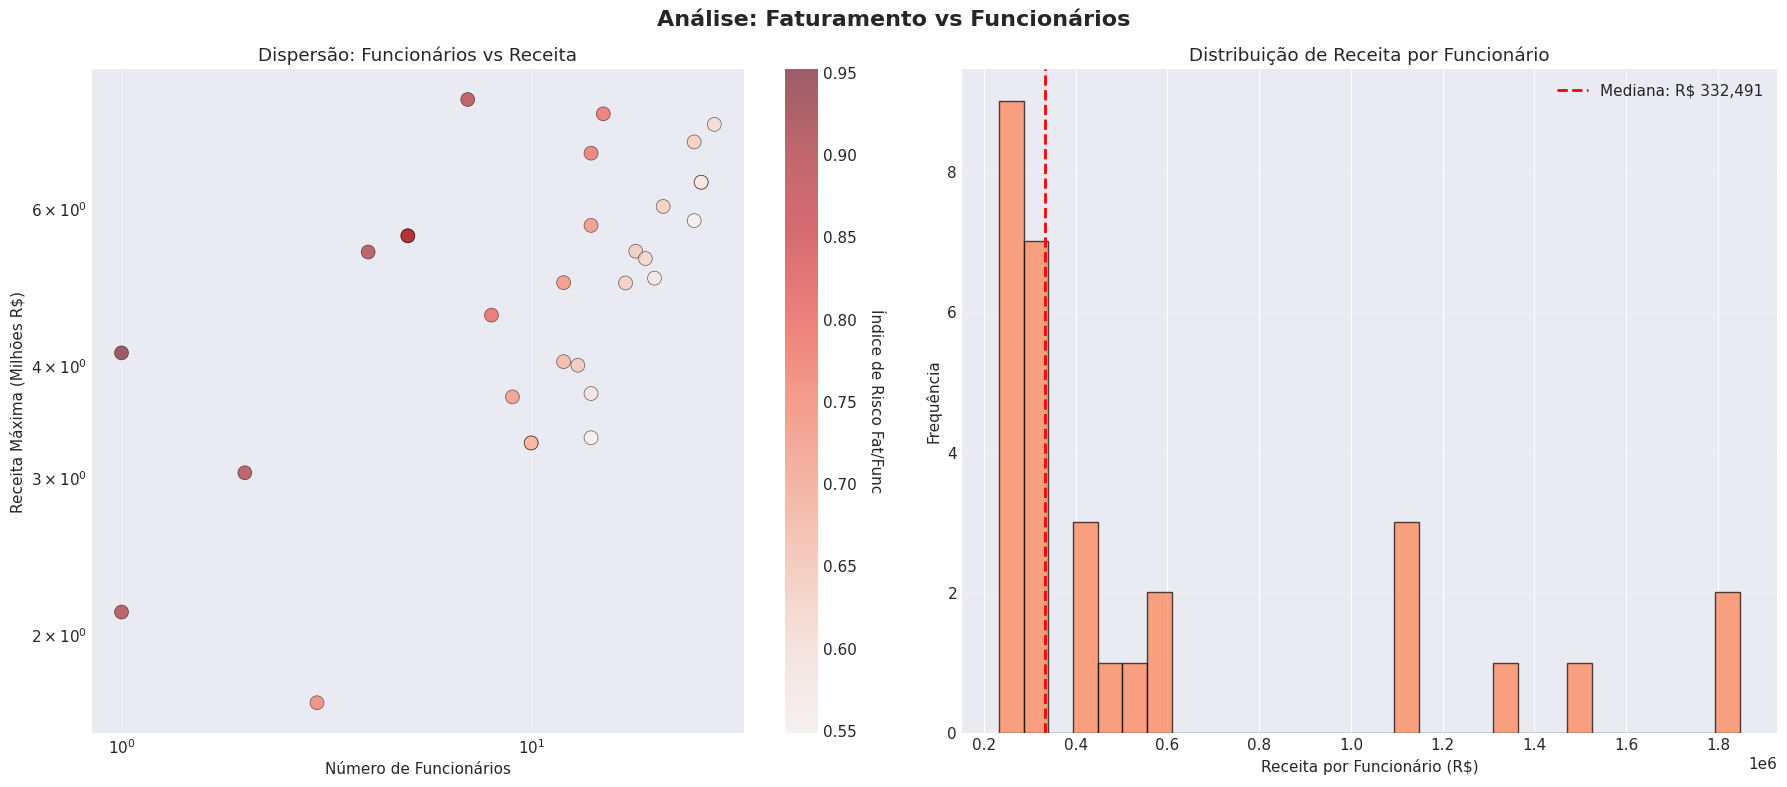

In [18]:
print("\n" + "=" * 80)
print("11. ANÁLISE: FATURAMENTO vs FUNCIONÁRIOS (Empresas Fantasma)")
print("=" * 80)

query_fat_func = """
SELECT 
    num_grupo,
    qntd_cnpj,
    valor_max AS receita_maxima,
    total_funcionarios,
    ROUND(indice_risco_fat_func, 4) AS indice_risco_fat_func,
    ROUND(valor_max / NULLIF(total_funcionarios, 0), 2) AS receita_por_funcionario,
    score_final_avancado
FROM gessimples.gei_percent
WHERE total_funcionarios > 0 AND valor_max > 0
ORDER BY indice_risco_fat_func DESC
LIMIT 30
"""

df_fat_func = spark.sql(query_fat_func).toPandas()

# CONVERTER TODOS OS CAMPOS NUMÉRICOS PARA FLOAT
df_fat_func['receita_maxima'] = df_fat_func['receita_maxima'].astype(float)
df_fat_func['total_funcionarios'] = df_fat_func['total_funcionarios'].astype(float)
df_fat_func['indice_risco_fat_func'] = df_fat_func['indice_risco_fat_func'].astype(float)
df_fat_func['receita_por_funcionario'] = df_fat_func['receita_por_funcionario'].astype(float)
df_fat_func['score_final_avancado'] = df_fat_func['score_final_avancado'].astype(float)

print("\nTOP 10 GRUPOS COM MAIOR DESPROPORÇÃO FATURAMENTO/FUNCIONÁRIOS:\n")
for idx, row in df_fat_func.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Receita Máxima: R$ {row['receita_maxima']:,.2f}")
    print(f"    Total Funcionários: {int(row['total_funcionarios'])}")
    print(f"    Receita por Funcionário: R$ {row['receita_por_funcionario']:,.2f}")
    print(f"    Índice de Risco Fat/Func: {row['indice_risco_fat_func']:.4f}")
    print(f"    Score Final: {row['score_final_avancado']:.2f}")
    print()

# Análise específica de alto risco (empresas fantasma)
query_fantasma = """
SELECT 
    num_grupo,
    qntd_cnpj,
    valor_max AS receita_maxima,
    total_funcionarios,
    ROUND(indice_risco_fat_func, 4) AS indice_risco_fat_func,
    ROUND(COALESCE(perc_ip_transmissao, 0), 2) AS perc_ip,
    ROUND(COALESCE(perc_end_emit, 0), 2) AS perc_end,
    score_final_avancado
FROM gessimples.gei_percent
WHERE total_funcionarios <= 5 
    AND valor_max > 1000000
ORDER BY valor_max DESC
LIMIT 20
"""

df_fantasma = spark.sql(query_fantasma).toPandas()

# CONVERTER CAMPOS NUMÉRICOS PARA FLOAT
df_fantasma['receita_maxima'] = df_fantasma['receita_maxima'].astype(float)
df_fantasma['total_funcionarios'] = df_fantasma['total_funcionarios'].astype(float)
df_fantasma['indice_risco_fat_func'] = df_fantasma['indice_risco_fat_func'].astype(float)
df_fantasma['perc_ip'] = df_fantasma['perc_ip'].astype(float)
df_fantasma['perc_end'] = df_fantasma['perc_end'].astype(float)
df_fantasma['score_final_avancado'] = df_fantasma['score_final_avancado'].astype(float)

print("\nGRUPOS COM PERFIL DE 'EMPRESA FANTASMA' (≤5 funcionários, >R$1M receita):\n")
for idx, row in df_fantasma.head(10).iterrows():
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    Receita: R$ {row['receita_maxima']:,.2f} | Funcionários: {int(row['total_funcionarios'])}")
    print(f"    Compartilha IP: {row['perc_ip']:.0%} | Compartilha Endereço: {row['perc_end']:.0%}")
    print(f"    Score: {row['score_final_avancado']:.2f}")
    print()

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise: Faturamento vs Funcionários', fontsize=16, fontweight='bold')

scatter1 = ax1.scatter(df_fat_func['total_funcionarios'], 
                       df_fat_func['receita_maxima']/1e6,
                       s=100, alpha=0.6, 
                       c=df_fat_func['indice_risco_fat_func'],
                       cmap='Reds', edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Número de Funcionários')
ax1.set_ylabel('Receita Máxima (Milhões R$)')
ax1.set_title('Dispersão: Funcionários vs Receita')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Índice de Risco Fat/Func', rotation=270, labelpad=20)

# Histograma de receita por funcionário - AGORA COM FLOAT
receita_por_func = df_fat_func['receita_por_funcionario'].clip(
    upper=df_fat_func['receita_por_funcionario'].quantile(0.95)
)

ax2.hist(receita_por_func, bins=30, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(receita_por_func.median(), color='red', linestyle='--', linewidth=2, 
            label=f'Mediana: R$ {receita_por_func.median():,.0f}')
ax2.set_xlabel('Receita por Funcionário (R$)')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição de Receita por Funcionário')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


12. ANÁLISE COMPARATIVA MULTI-DIMENSIONAL



MATRIZ DE CORRELAÇÃO ENTRE COMPONENTES DE RISCO:

                       score_inconsistencias  score_cadastro  \
score_inconsistencias                  1.000           0.853   
score_cadastro                         0.853           1.000   
indice_interconexao                   -0.122          -0.159   
risco_c115                            -0.008           0.066   
risco_indicios                         0.031           0.012   
risco_pagamentos                       0.166           0.091   
risco_fat_func                         0.214           0.302   

                       indice_interconexao  risco_c115  risco_indicios  \
score_inconsistencias               -0.122      -0.008           0.031   
score_cadastro                      -0.159       0.066           0.012   
indice_interconexao                  1.000       0.080          -0.009   
risco_c115                           0.080       1.000          -0.674   
risco_indicios                      -0.009      -0.674           1

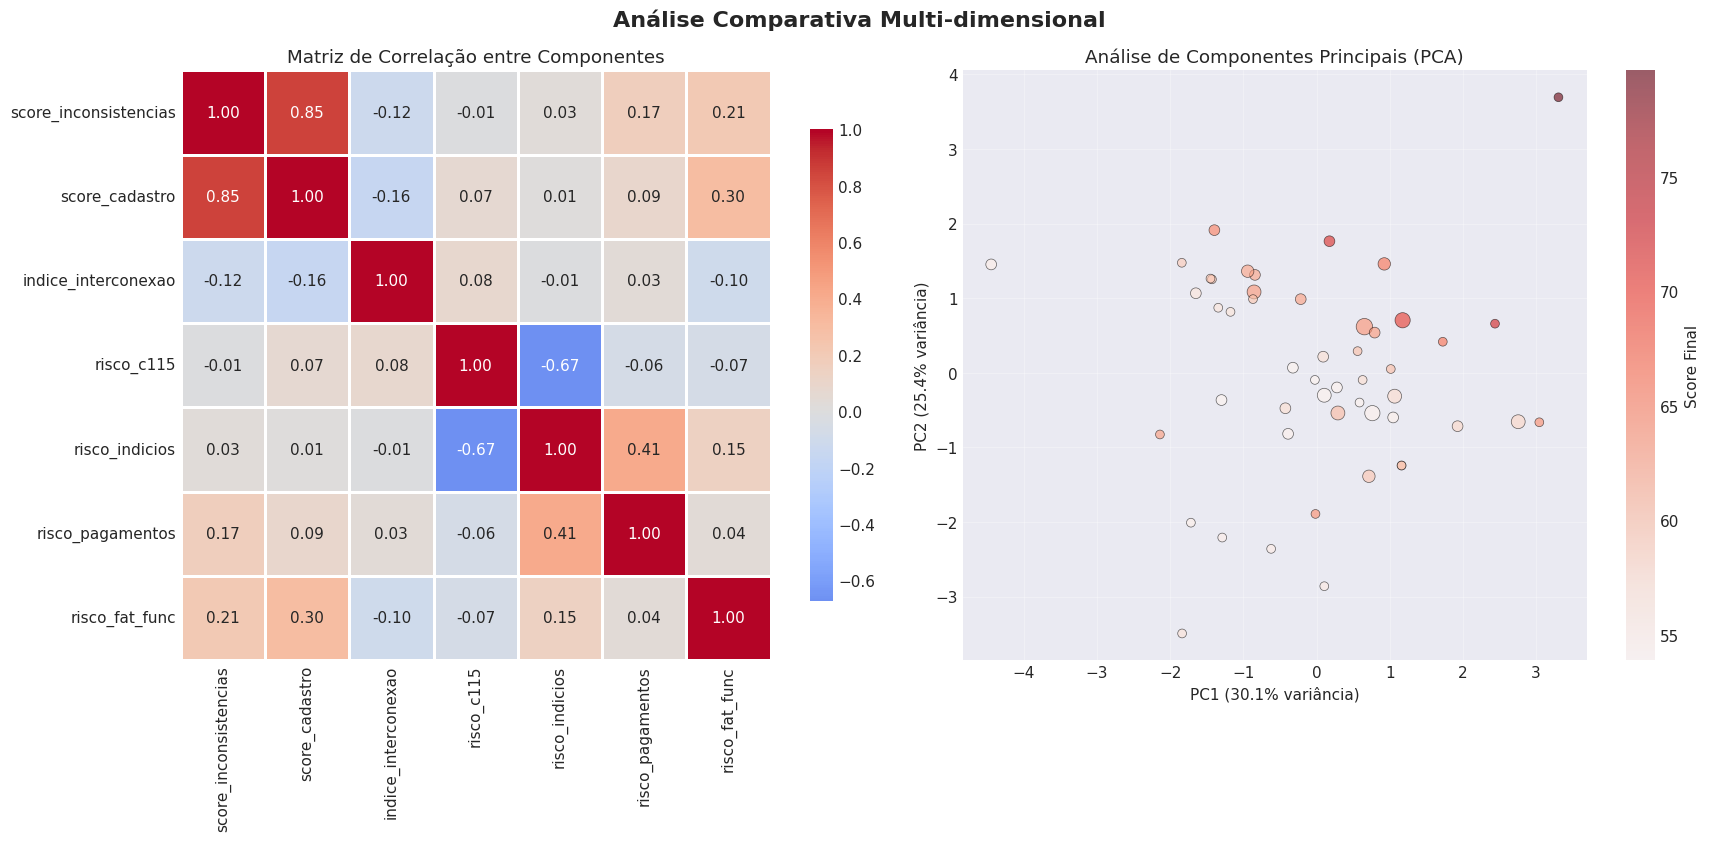

In [20]:
print("\n" + "=" * 80)
print("12. ANÁLISE COMPARATIVA MULTI-DIMENSIONAL")
print("=" * 80)

query_multidimensional = """
SELECT 
    num_grupo,
    score_final_avancado,
    ROUND(total, 2) AS score_inconsistencias,
    ROUND(total_cadastro, 2) AS score_cadastro,
    ROUND(indice_interconexao, 4) AS indice_interconexao,
    ROUND(indice_risco_grupo_economico, 4) AS risco_c115,
    ROUND(indice_risco_indicios, 4) AS risco_indicios,
    ROUND(indice_risco_pagamentos, 4) AS risco_pagamentos,
    ROUND(indice_risco_fat_func, 4) AS risco_fat_func,
    qntd_cnpj,
    valor_max AS receita_maxima
FROM gessimples.gei_percent
WHERE score_final_avancado >= 10
ORDER BY score_final_avancado DESC
LIMIT 50
"""

df_multi = spark.sql(query_multidimensional).toPandas()
df_multi['receita_maxima'] = df_multi['receita_maxima'].astype(float)

# Análise de correlação entre componentes
componentes = ['score_inconsistencias', 'score_cadastro', 'indice_interconexao', 
               'risco_c115', 'risco_indicios', 'risco_pagamentos', 'risco_fat_func']

correlacao = df_multi[componentes].corr()

print("\nMATRIZ DE CORRELAÇÃO ENTRE COMPONENTES DE RISCO:\n")
print(correlacao.round(3))

# Análise de componentes principais (visual)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preparar dados
X = df_multi[componentes].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_multi['PC1'] = X_pca[:, 0]
df_multi['PC2'] = X_pca[:, 1]

print(f"\nVARIÂNCIA EXPLICADA POR COMPONENTES PRINCIPAIS:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.1%}")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Análise Comparativa Multi-dimensional', fontsize=16, fontweight='bold')

# Heatmap de correlação
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Matriz de Correlação entre Componentes')

# PCA Scatter
scatter = ax2.scatter(df_multi['PC1'], df_multi['PC2'],
                      s=df_multi['qntd_cnpj']*20,
                      alpha=0.6, c=df_multi['score_final_avancado'],
                      cmap='Reds', edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)')
ax2.set_title('Análise de Componentes Principais (PCA)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Score Final')

plt.tight_layout()
plt.show()

In [21]:
print("\n" + "=" * 80)
print("13. DOSSIÊ COMPLETO DE GRUPO ESPECÍFICO")
print("=" * 80)

# MODIFIQUE ESTE VALOR PARA O GRUPO QUE DESEJA ANALISAR
GRUPO_ALVO = 101

print(f"\nAnalisando Grupo: {GRUPO_ALVO}\n")

# Métricas principais
query_grupo_principal = f"""
SELECT 
    num_grupo,
    qntd_cnpj,
    score_final_avancado,
    total AS score_inconsistencias,
    total_cadastro AS score_cadastro,
    indice_interconexao,
    indice_risco_grupo_economico,
    indice_risco_indicios,
    indice_risco_pagamentos,
    indice_risco_fat_func,
    valor_max AS receita_maxima,
    periodo_max,
    total_funcionarios,
    valor_meios_pagamento_empresas,
    valor_meios_pagamento_socios,
    nivel_risco_grupo_economico,
    qtd_socios_compartilhados,
    qtd_total_indicios
FROM gessimples.gei_percent
WHERE num_grupo = {GRUPO_ALVO}
"""

df_grupo = spark.sql(query_grupo_principal).toPandas()

if df_grupo.empty:
    print(f"ERRO: Grupo {GRUPO_ALVO} não encontrado na base de dados.")
else:
    row = df_grupo.iloc[0]
    
    print("=" * 60)
    print("MÉTRICAS PRINCIPAIS")
    print("=" * 60)
    print(f"CNPJs no Grupo: {int(row['qntd_cnpj'])}")
    print(f"Score Final de Risco: {row['score_final_avancado']:.2f}")
    print(f"Nível de Risco C115: {row['nivel_risco_grupo_economico']}")
    print(f"\nRECEITA:")
    print(f"  Máxima (12m): R$ {float(row['receita_maxima']):,.2f}")
    print(f"  Período Máximo: {row['periodo_max']}")
    print(f"\nESTRUTURA:")
    print(f"  Funcionários: {int(row['total_funcionarios'])}")
    print(f"  Sócios Compartilhados: {int(row['qtd_socios_compartilhados'])}")
    print(f"\nCOMPONENTES DE RISCO:")
    print(f"  Inconsistências: {row['score_inconsistencias']:.2f}")
    print(f"  Cadastro: {row['score_cadastro']:.2f}")
    print(f"  Interconexão: {row['indice_interconexao']:.4f}")
    print(f"  C115: {row['indice_risco_grupo_economico']:.4f}")
    print(f"  Indícios: {row['indice_risco_indicios']:.4f}")
    print(f"  Pagamentos: {row['indice_risco_pagamentos']:.4f}")
    print(f"  Fat/Func: {row['indice_risco_fat_func']:.4f}")
    print(f"\nINDÍCIOS FISCAIS:")
    print(f"  Total: {int(row['qtd_total_indicios'])}")
    
    # CNPJs do grupo
    query_cnpjs = f"""
    SELECT 
        c.cnpj,
        cad.nm_razao_social,
        cad.nm_fantasia,
        cad.cd_cnae,
        cad.nm_reg_apuracao
    FROM gessimples.gei_cnpj c
    LEFT JOIN gessimples.gei_cadastro cad ON c.cnpj = cad.nu_cnpj
    WHERE c.num_grupo = {GRUPO_ALVO}
    """
    
    df_cnpjs = spark.sql(query_cnpjs).toPandas()
    
    print("\n" + "=" * 60)
    print("CNPJs DO GRUPO")
    print("=" * 60)
    for idx, cnpj_row in df_cnpjs.iterrows():
        print(f"{idx+1}. {cnpj_row['cnpj']}")
        print(f"   Razão Social: {cnpj_row['nm_razao_social']}")
        print(f"   Nome Fantasia: {cnpj_row['nm_fantasia']}")
        print(f"   CNAE: {cnpj_row['cd_cnae']} | Regime: {cnpj_row['nm_reg_apuracao']}")
        print()
    
    # Sócios compartilhados
    query_socios = f"""
    SELECT 
        cpf_socio,
        COUNT(DISTINCT cnpj) AS qtd_empresas,
        MAX(nm_relacao) AS tipo_relacao
    FROM gessimples.gei_socios_compartilhados
    WHERE num_grupo = {GRUPO_ALVO}
    GROUP BY cpf_socio
    ORDER BY qtd_empresas DESC
    """
    
    df_socios = spark.sql(query_socios).toPandas()
    
    if not df_socios.empty:
        print("=" * 60)
        print("SÓCIOS COMPARTILHADOS")
        print("=" * 60)
        for idx, socio_row in df_socios.iterrows():
            print(f"{idx+1}. CPF: {socio_row['cpf_socio']}")
            print(f"   Conecta: {int(socio_row['qtd_empresas'])} empresas")
            print(f"   Tipo: {socio_row['tipo_relacao']}")
            print()
    
    # Indícios
    query_indicios_grupo = f"""
    SELECT 
        tx_descricao_indicio,
        COUNT(*) AS qtd
    FROM gessimples.gei_indicios
    WHERE num_grupo = {GRUPO_ALVO}
    GROUP BY tx_descricao_indicio
    ORDER BY qtd DESC
    """
    
    df_indicios_grupo = spark.sql(query_indicios_grupo).toPandas()
    
    if not df_indicios_grupo.empty:
        print("=" * 60)
        print("INDÍCIOS FISCAIS IDENTIFICADOS")
        print("=" * 60)
        for idx, indicio_row in df_indicios_grupo.iterrows():
            print(f"{idx+1}. {indicio_row['tx_descricao_indicio']}")
            print(f"   Ocorrências: {int(indicio_row['qtd'])}")
            print()
    
    # Visualização do grupo
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Dossiê Completo - Grupo {GRUPO_ALVO}', fontsize=16, fontweight='bold')
    
    # Decomposição do score
    componentes_scores = {
        'Inconsistências': row['score_inconsistencias'],
        'Cadastro': row['score_cadastro'],
        'Interconexão': row['indice_interconexao'] * 10,
        'C115': row['indice_risco_grupo_economico'],
        'Indícios': row['indice_risco_indicios'] * 20,
        'Pagamentos': row['indice_risco_pagamentos'] * 10,
        'Fat/Func': row['indice_risco_fat_func'] * 10
    }
    
    ax1.bar(range(len(componentes_scores)), list(componentes_scores.values()),
            color=plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(componentes_scores))))
    ax1.set_xticks(range(len(componentes_scores)))
    ax1.set_xticklabels(list(componentes_scores.keys()), rotation=45, ha='right')
    ax1.set_ylabel('Score')
    ax1.set_title('Decomposição do Score de Risco')
    ax1.grid(axis='y', alpha=0.3)
    
    # Estrutura do grupo
    if not df_cnpjs.empty:
        ax2.text(0.5, 0.8, f"Grupo {GRUPO_ALVO}", ha='center', fontsize=20, fontweight='bold')
        ax2.text(0.5, 0.6, f"{int(row['qntd_cnpj'])} CNPJs", ha='center', fontsize=16)
        ax2.text(0.5, 0.45, f"{int(row['qtd_socios_compartilhados'])} Sócios Compartilhados", ha='center', fontsize=14)
        ax2.text(0.5, 0.3, f"Score: {row['score_final_avancado']:.2f}", ha='center', fontsize=14, 
                color='red' if row['score_final_avancado'] >= 15 else 'orange')
        ax2.axis('off')
        ax2.set_title('Resumo Estrutural')
    
    # Indícios (se houver)
    if not df_indicios_grupo.empty and len(df_indicios_grupo) > 0:
        top_indicios = df_indicios_grupo.head(10)
        ax3.barh(range(len(top_indicios)), top_indicios['qtd'], color='coral')
        ax3.set_yticks(range(len(top_indicios)))
        ax3.set_yticklabels([i[:40] + '...' if len(i) > 40 else i 
                             for i in top_indicios['tx_descricao_indicio']])
        ax3.set_xlabel('Quantidade')
        ax3.set_title('Principais Indícios Fiscais')
        ax3.invert_yaxis()
    else:
        ax3.text(0.5, 0.5, 'Sem indícios fiscais registrados', ha='center', va='center', fontsize=12)
        ax3.axis('off')
    
    # Comparação com médias gerais
    medias_gerais = spark.sql("""
    SELECT 
        AVG(score_final_avancado) AS avg_score,
        AVG(total) AS avg_inconsistencias,
        AVG(indice_interconexao) AS avg_interconexao,
        AVG(indice_risco_grupo_economico) AS avg_c115
    FROM gessimples.gei_percent
    """).collect()[0]
    
    categorias = ['Score Final', 'Inconsistências', 'Interconexão', 'Risco C115']
    valores_grupo = [
        row['score_final_avancado'],
        row['score_inconsistencias'],
        row['indice_interconexao'] * 10,
        row['indice_risco_grupo_economico']
    ]
    valores_media = [
        medias_gerais['avg_score'],
        medias_gerais['avg_inconsistencias'],
        medias_gerais['avg_interconexao'] * 10,
        medias_gerais['avg_c115']
    ]
    
    x = np.arange(len(categorias))
    width = 0.35
    
    ax4.bar(x - width/2, valores_grupo, width, label='Grupo Analisado', color='red', alpha=0.7)
    ax4.bar(x + width/2, valores_media, width, label='Média Geral', color='blue', alpha=0.7)
    ax4.set_xticks(x)
    ax4.set_xticklabels(categorias, rotation=45, ha='right')
    ax4.set_ylabel('Valor')
    ax4.set_title('Comparação com Médias Gerais')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


13. DOSSIÊ COMPLETO DE GRUPO ESPECÍFICO

Analisando Grupo: 101

ERRO: Grupo 101 não encontrado na base de dados.



14. DASHBOARD EXECUTIVO - VISÃO CONSOLIDADA


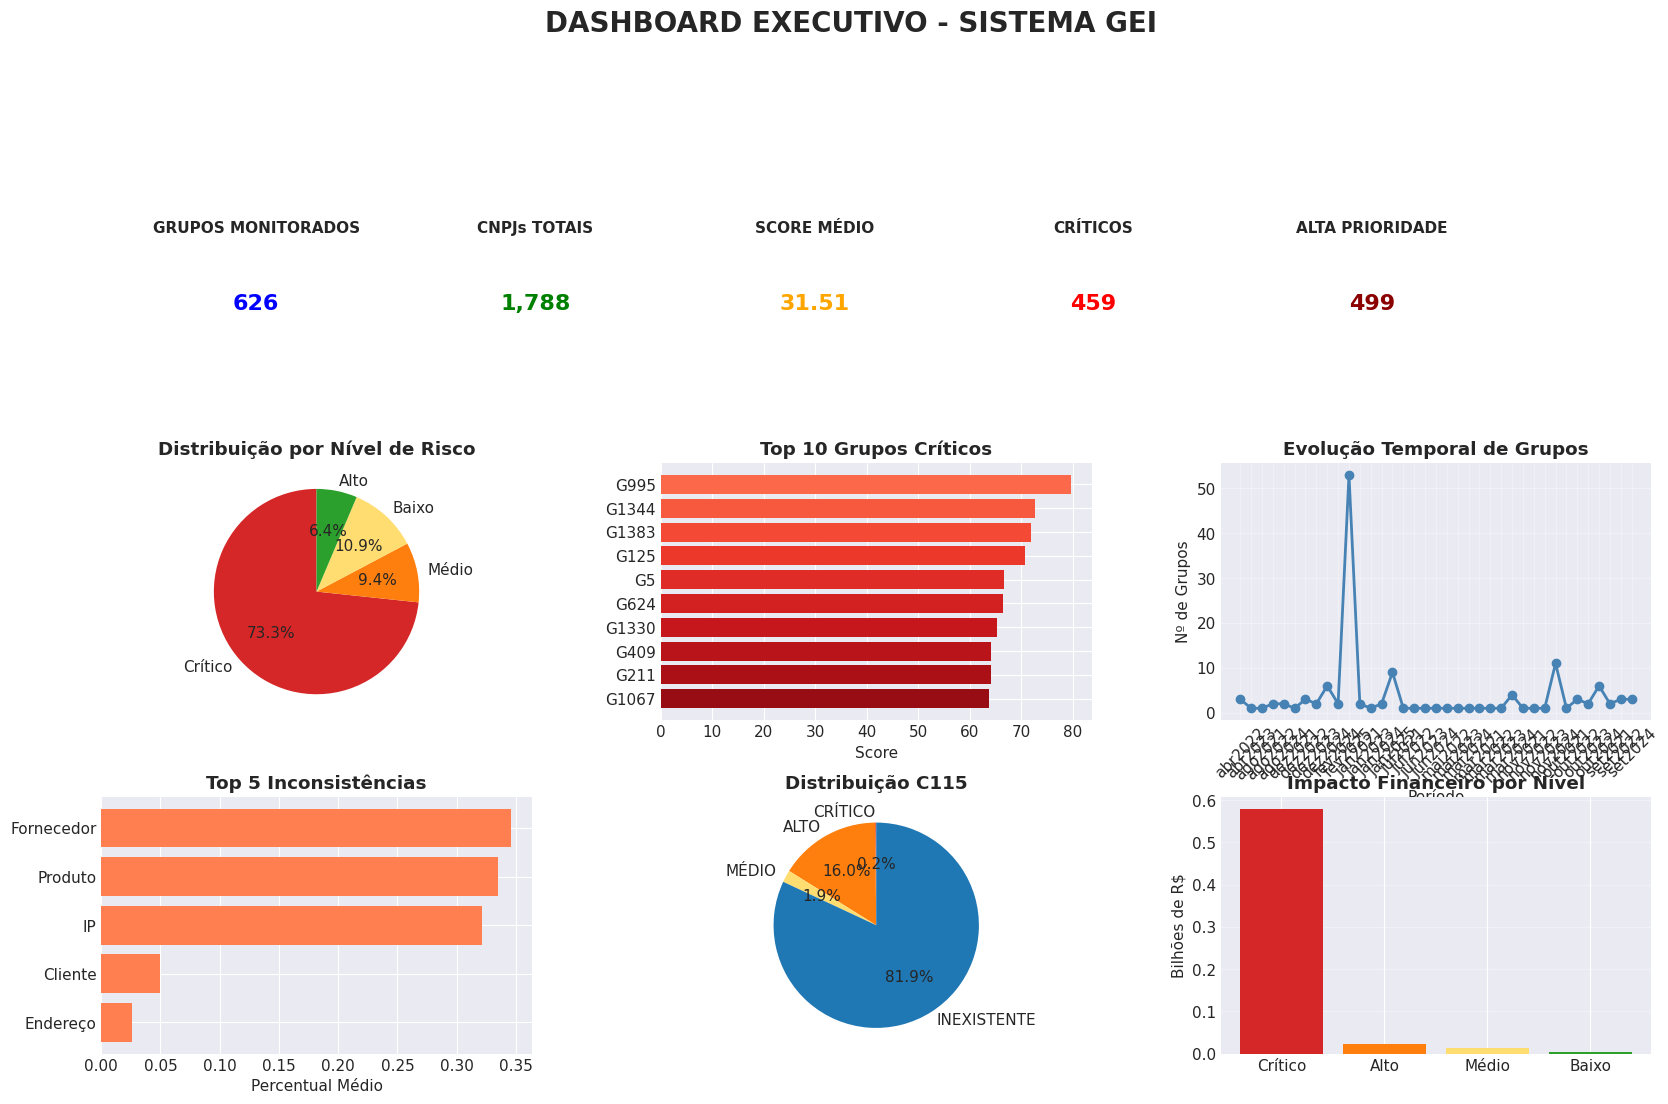


RECOMENDAÇÕES PARA AÇÃO FISCAL:
1. PRIORIDADE MÁXIMA: Fiscalizar 459 grupos críticos (score ≥ 20)
2. ALTA PRIORIDADE: Auditar 40 grupos de alto risco (score 15-20)
3. ATENÇÃO: Monitorar 71 grupos acima do limite do Simples Nacional
4. SISTEMA: 10580 indícios fiscais identificados no sistema

Receita Total Monitorada: R$ 0.62 bilhões


In [25]:
print("\n" + "=" * 80)
print("14. DASHBOARD EXECUTIVO - VISÃO CONSOLIDADA")
print("=" * 80)

# Métricas consolidadas
query_dashboard = """
SELECT 
    COUNT(DISTINCT num_grupo) AS total_grupos,
    SUM(qntd_cnpj) AS total_cnpjs,
    ROUND(AVG(score_final_avancado), 2) AS score_medio,
    COUNT(CASE WHEN score_final_avancado >= 20 THEN 1 END) AS grupos_criticos,
    COUNT(CASE WHEN score_final_avancado >= 15 THEN 1 END) AS grupos_alta_prioridade,
    COUNT(CASE WHEN valor_max >= 4800000 THEN 1 END) AS acima_limite_sn,
    SUM(COALESCE(valor_max, 0)) AS receita_total,
    SUM(total_funcionarios) AS total_funcionarios,
    SUM(qtd_total_indicios) AS total_indicios_sistema
FROM gessimples.gei_percent
"""

dashboard = spark.sql(query_dashboard).collect()[0]

# Criar figura do dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('DASHBOARD EXECUTIVO - SISTEMA GEI', fontsize=20, fontweight='bold', y=0.98)

# KPIs principais
ax_kpi = fig.add_subplot(gs[0, :])
ax_kpi.axis('off')

kpis = [
    ('GRUPOS MONITORADOS', f"{dashboard['total_grupos']:,}", 'blue'),
    ('CNPJs TOTAIS', f"{dashboard['total_cnpjs']:,}", 'green'),
    ('SCORE MÉDIO', f"{dashboard['score_medio']:.2f}", 'orange'),
    ('CRÍTICOS', f"{dashboard['grupos_criticos']:,}", 'red'),
    ('ALTA PRIORIDADE', f"{dashboard['grupos_alta_prioridade']:,}", 'darkred'),
]

for i, (label, value, color) in enumerate(kpis):
    x_pos = 0.1 + i * 0.18
    ax_kpi.text(x_pos, 0.6, label, ha='center', fontsize=11, fontweight='bold')
    ax_kpi.text(x_pos, 0.3, value, ha='center', fontsize=16, fontweight='bold', color=color)

# Distribuição de risco
ax1 = fig.add_subplot(gs[1, 0])
dist_risco_dash = spark.sql("""
SELECT 
    CASE 
        WHEN score_final_avancado >= 20 THEN 'Crítico'
        WHEN score_final_avancado >= 15 THEN 'Alto'
        WHEN score_final_avancado >= 10 THEN 'Médio'
        ELSE 'Baixo'
    END AS nivel,
    COUNT(*) AS qtd
FROM gessimples.gei_percent
GROUP BY 1
""").toPandas()

colors_dash = ['#d62728', '#ff7f0e', '#ffdd70', '#2ca02c']
ax1.pie(dist_risco_dash['qtd'], labels=dist_risco_dash['nivel'], autopct='%1.1f%%',
        colors=colors_dash, startangle=90)
ax1.set_title('Distribuição por Nível de Risco', fontweight='bold')

# Top 10 grupos críticos
ax2 = fig.add_subplot(gs[1, 1])
top10_dash = spark.sql("""
SELECT num_grupo, score_final_avancado
FROM gessimples.gei_percent
ORDER BY score_final_avancado DESC
LIMIT 10
""").toPandas()

ax2.barh(range(len(top10_dash)), top10_dash['score_final_avancado'], 
         color=plt.cm.Reds(np.linspace(0.5, 0.9, len(top10_dash))))
ax2.set_yticks(range(len(top10_dash)))
ax2.set_yticklabels([f'G{int(g)}' for g in top10_dash['num_grupo']])
ax2.set_xlabel('Score')
ax2.set_title('Top 10 Grupos Críticos', fontweight='bold')
ax2.invert_yaxis()

# Evolução temporal (últimos 6 meses)
ax3 = fig.add_subplot(gs[1, 2])
evolucao_temp = spark.sql("""
SELECT 
    periodo_max,
    COUNT(*) AS grupos
FROM gessimples.gei_percent
WHERE periodo_max IS NOT NULL
    AND periodo_max >= '202409'
GROUP BY periodo_max
ORDER BY periodo_max
""").toPandas()

if not evolucao_temp.empty:
    ax3.plot(evolucao_temp['periodo_max'], evolucao_temp['grupos'], 
             marker='o', linewidth=2, color='steelblue')
    ax3.set_xlabel('Período')
    ax3.set_ylabel('Nº de Grupos')
    ax3.set_title('Evolução Temporal de Grupos', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

# Inconsistências mais comuns
ax4 = fig.add_subplot(gs[2, 0])
incons_resumo = spark.sql("""
SELECT 'IP' AS tipo, AVG(perc_ip_transmissao) AS media FROM gessimples.gei_percent
UNION ALL SELECT 'Endereço', AVG(perc_end_emit) FROM gessimples.gei_percent
UNION ALL SELECT 'Cliente', AVG(perc_cliente) FROM gessimples.gei_percent
UNION ALL SELECT 'Fornecedor', AVG(perc_fornecedor) FROM gessimples.gei_percent
UNION ALL SELECT 'Produto', AVG(perc_codigo_produto) FROM gessimples.gei_percent
ORDER BY media DESC
LIMIT 5
""").toPandas()

ax4.barh(range(len(incons_resumo)), incons_resumo['media'], color='coral')
ax4.set_yticks(range(len(incons_resumo)))
ax4.set_yticklabels(incons_resumo['tipo'])
ax4.set_xlabel('Percentual Médio')
ax4.set_title('Top 5 Inconsistências', fontweight='bold')
ax4.invert_yaxis()

# Distribuição C115
ax5 = fig.add_subplot(gs[2, 1])
c115_resumo = spark.sql("""
SELECT 
    nivel_risco_grupo_economico,
    COUNT(*) AS qtd
FROM gessimples.gei_percent
WHERE nivel_risco_grupo_economico IS NOT NULL
GROUP BY nivel_risco_grupo_economico
ORDER BY CASE nivel_risco_grupo_economico
    WHEN 'CRÍTICO' THEN 1
    WHEN 'ALTO' THEN 2
    WHEN 'MÉDIO' THEN 3
    ELSE 4
END
""").toPandas()

colors_c115_dash = {'CRÍTICO': '#d62728', 'ALTO': '#ff7f0e', 'MÉDIO': '#ffdd70', 
                     'BAIXO': '#2ca02c', 'INEXISTENTE': '#1f77b4'}
colors_list_c115 = [colors_c115_dash.get(n, '#7f7f7f') for n in c115_resumo['nivel_risco_grupo_economico']]

ax5.pie(c115_resumo['qtd'], labels=c115_resumo['nivel_risco_grupo_economico'], 
        autopct='%1.1f%%', colors=colors_list_c115, startangle=90)
ax5.set_title('Distribuição C115', fontweight='bold')

# Impacto financeiro
ax6 = fig.add_subplot(gs[2, 2])
impacto_fin = spark.sql("""
SELECT 
    CASE 
        WHEN score_final_avancado >= 20 THEN 'Crítico'
        WHEN score_final_avancado >= 15 THEN 'Alto'
        WHEN score_final_avancado >= 10 THEN 'Médio'
        ELSE 'Baixo'
    END AS nivel,
    SUM(COALESCE(valor_max, 0)) AS bc_total
FROM gessimples.gei_percent
GROUP BY 1
ORDER BY MIN(score_final_avancado) DESC
""").toPandas()

impacto_fin['bc_total'] = impacto_fin['bc_total'].astype(float)

ax6.bar(range(len(impacto_fin)), impacto_fin['bc_total']/1e9, color=colors_dash)
ax6.set_xticks(range(len(impacto_fin)))
ax6.set_xticklabels(impacto_fin['nivel'])
ax6.set_ylabel('Bilhões de R$')
ax6.set_title('Impacto Financeiro por Nível', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("RECOMENDAÇÕES PARA AÇÃO FISCAL:")
print("=" * 80)
print(f"1. PRIORIDADE MÁXIMA: Fiscalizar {dashboard['grupos_criticos']} grupos críticos (score ≥ 20)")
print(f"2. ALTA PRIORIDADE: Auditar {dashboard['grupos_alta_prioridade'] - dashboard['grupos_criticos']} grupos de alto risco (score 15-20)")
print(f"3. ATENÇÃO: Monitorar {dashboard['acima_limite_sn']} grupos acima do limite do Simples Nacional")
print(f"4. SISTEMA: {dashboard['total_indicios_sistema']} indícios fiscais identificados no sistema")
print("\nReceita Total Monitorada: R$ {:.2f} bilhões".format(float(dashboard['receita_total'])/1e9))
print("=" * 80)

In [26]:
print("\n" + "=" * 80)
print("15. EXPORTAÇÃO DE RELATÓRIOS PARA ANÁLISE")
print("=" * 80)

# Relatório executivo dos grupos críticos
relatorio_criticos = spark.sql("""
SELECT 
    num_grupo,
    qntd_cnpj,
    score_final_avancado,
    ROUND(total, 2) AS score_inconsistencias,
    ROUND(indice_interconexao, 4) AS indice_interconexao,
    nivel_risco_grupo_economico,
    valor_max AS receita_maxima,
    total_funcionarios,
    qtd_total_indicios,
    qtd_socios_compartilhados
FROM gessimples.gei_percent
WHERE score_final_avancado >= 15
ORDER BY score_final_avancado DESC
""")

relatorio_criticos_pd = relatorio_criticos.toPandas()
relatorio_criticos_pd['receita_maxima'] = relatorio_criticos_pd['receita_maxima'].astype(float)

print(f"\nTotal de grupos de alta prioridade: {len(relatorio_criticos_pd)}")
print(f"\nPrimeiros 20 registros do relatório:")
print(relatorio_criticos_pd.head(20).to_string(index=False))

# Salvar em formato CSV (opcional - descomente se quiser exportar)
# relatorio_criticos_pd.to_csv('relatorio_grupos_criticos.csv', index=False, encoding='utf-8-sig')
# print("\nRelatório exportado para 'relatorio_grupos_criticos.csv'")

# Estatísticas por contador
relatorio_contadores = spark.sql("""
SELECT 
    c.nm_contador,
    c.nm_gerfe,
    c.qntd_grupos,
    c.media AS score_medio,
    COUNT(CASE WHEN p.score_final_avancado >= 15 THEN 1 END) AS grupos_alto_risco,
    SUM(p.qntd_cnpj) AS total_cnpjs
FROM gessimples.gei_contador c
LEFT JOIN gessimples.gei_percent p ON c.nm_contador = p.nm_contador
WHERE c.qntd_grupos >= 3
GROUP BY c.nm_contador, c.nm_gerfe, c.qntd_grupos, c.media
HAVING COUNT(CASE WHEN p.score_final_avancado >= 15 THEN 1 END) > 0
ORDER BY grupos_alto_risco DESC, score_medio DESC
LIMIT 50
""")

relatorio_contadores_pd = relatorio_contadores.toPandas()

print(f"\n\nContadores com grupos de alto risco: {len(relatorio_contadores_pd)}")
print(f"\nTop 15 contadores:")
print(relatorio_contadores_pd.head(15).to_string(index=False))

# Opcional: exportar
# relatorio_contadores_pd.to_csv('relatorio_contadores_risco.csv', index=False, encoding='utf-8-sig')

print("\n" + "=" * 80)
print("ANÁLISE COMPLETA FINALIZADA")
print("=" * 80)


15. EXPORTAÇÃO DE RELATÓRIOS PARA ANÁLISE

Total de grupos de alta prioridade: 499

Primeiros 20 registros do relatório:
num_grupo  qntd_cnpj score_final_avancado  score_inconsistencias indice_interconexao nivel_risco_grupo_economico  receita_maxima  total_funcionarios  qtd_total_indicios  qtd_socios_compartilhados
      995          2                79.66                   4.09                1.00                 INEXISTENTE             NaN                  78                  37                          4
     1344          2                72.76                   4.67                1.00                 INEXISTENTE      5869675.66                  26                  35                          2
     1383          3                71.81                   2.35                1.00                 INEXISTENTE             NaN                 129                  45                          2
      125          6                70.67                   4.13                1.00          


16. ANÁLISE DE REDE SOCIETÁRIA - VISUALIZAÇÃO DE CONEXÕES

GRUPOS COM MAIOR INTERCONEXÃO SOCIETÁRIA:

 1. Grupo 1530
    CNPJs: 3 | Sócios Compartilhados: 15
    Índice Interconexão: 1.0000 | Densidade: 5.00
    Score: 57.25

 2. Grupo 1024
    CNPJs: 2 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 1.00
    Score: 51.24

 3. Grupo 952
    CNPJs: 2 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 1.00
    Score: 56.45

 4. Grupo 1344
    CNPJs: 2 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 1.00
    Score: 72.76

 5. Grupo 831
    CNPJs: 3 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 0.67
    Score: 54.92

 6. Grupo 125
    CNPJs: 6 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 0.33
    Score: 70.67

 7. Grupo 296
    CNPJs: 2 | Sócios Compartilhados: 2
    Índice Interconexão: 1.0000 | Densidade: 1.00
    Score: 55.43

 8. Grupo 624
    CNPJs: 4 | Sócios Com

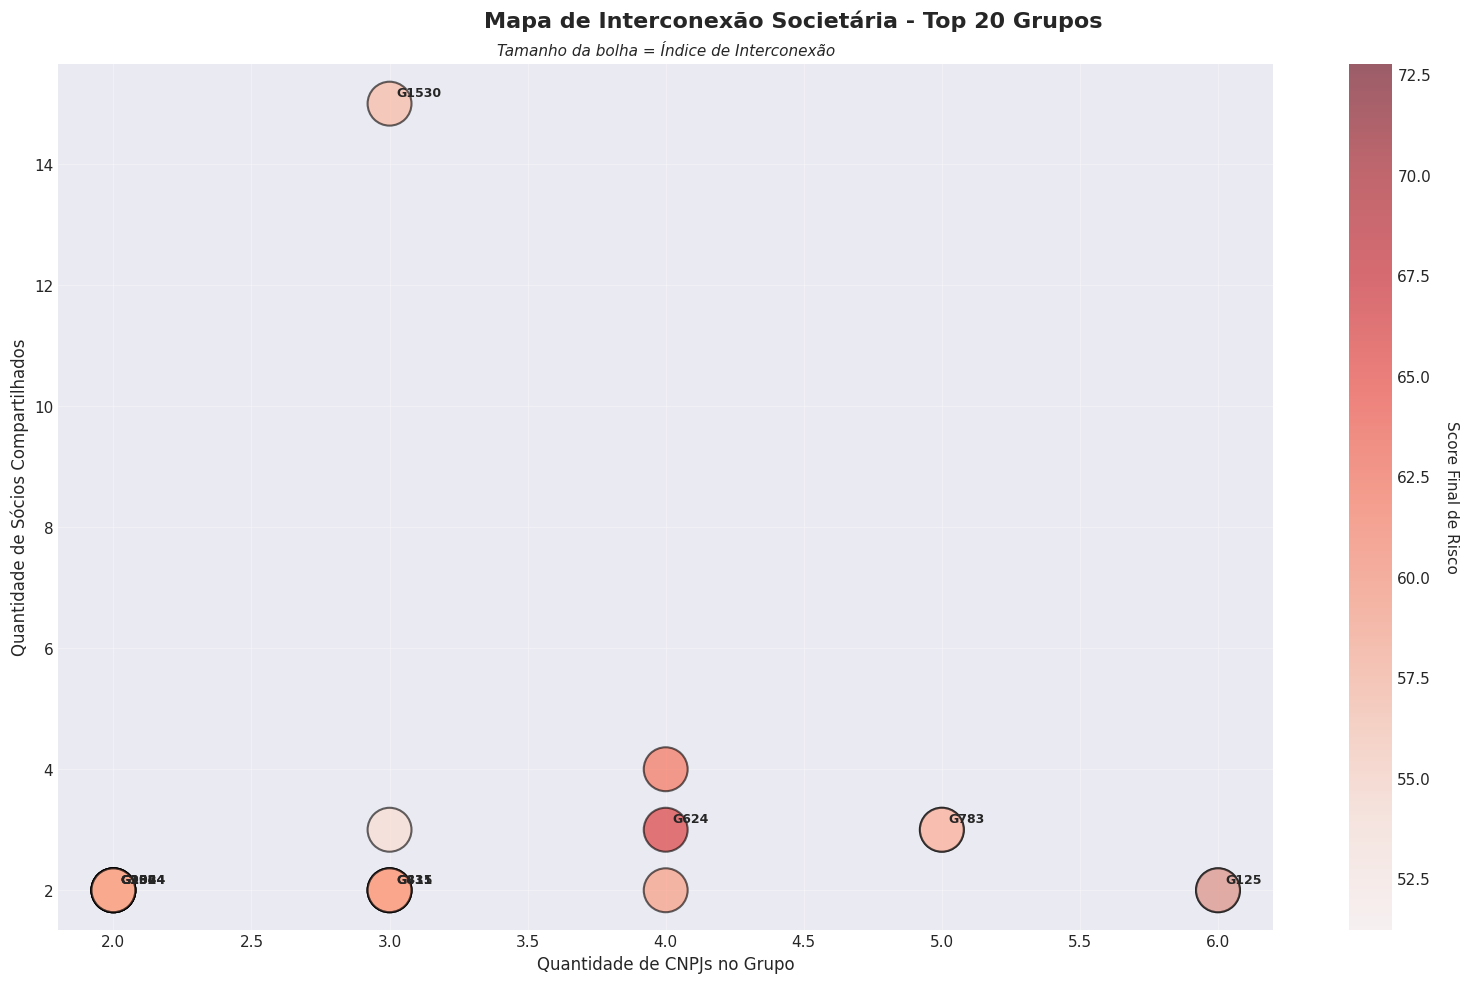

In [28]:
print("\n" + "=" * 80)
print("16. ANÁLISE DE REDE SOCIETÁRIA - VISUALIZAÇÃO DE CONEXÕES")
print("=" * 80)

# Selecionar grupos mais interconectados
query_rede = """
SELECT 
    num_grupo,
    qntd_cnpj,
    qtd_socios_compartilhados,
    indice_interconexao,
    score_final_avancado
FROM gessimples.gei_percent
WHERE qtd_socios_compartilhados >= 2
    AND score_final_avancado >= 10
ORDER BY indice_interconexao DESC
LIMIT 20
"""

df_rede = spark.sql(query_rede).toPandas()

# CONVERTER TODOS OS CAMPOS NUMÉRICOS PARA FLOAT
df_rede['qntd_cnpj'] = df_rede['qntd_cnpj'].astype(float)
df_rede['qtd_socios_compartilhados'] = df_rede['qtd_socios_compartilhados'].astype(float)
df_rede['indice_interconexao'] = df_rede['indice_interconexao'].astype(float)
df_rede['score_final_avancado'] = df_rede['score_final_avancado'].astype(float)

print("\nGRUPOS COM MAIOR INTERCONEXÃO SOCIETÁRIA:\n")
for idx, row in df_rede.head(10).iterrows():
    densidade = row['qtd_socios_compartilhados'] / row['qntd_cnpj'] if row['qntd_cnpj'] > 0 else 0
    print(f"{idx+1:2d}. Grupo {row['num_grupo']}")
    print(f"    CNPJs: {int(row['qntd_cnpj'])} | Sócios Compartilhados: {int(row['qtd_socios_compartilhados'])}")
    print(f"    Índice Interconexão: {row['indice_interconexao']:.4f} | Densidade: {densidade:.2f}")
    print(f"    Score: {row['score_final_avancado']:.2f}")
    print()

# Visualização de rede (simplificada)
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Mapa de Interconexão Societária - Top 20 Grupos', fontsize=16, fontweight='bold')

# Criar gráfico de bolhas - AGORA COM FLOAT
scatter = ax.scatter(df_rede['qntd_cnpj'], 
                     df_rede['qtd_socios_compartilhados'],
                     s=df_rede['indice_interconexao']*1000,  # Agora funciona porque é float
                     alpha=0.6,
                     c=df_rede['score_final_avancado'],
                     cmap='Reds',
                     edgecolors='black',
                     linewidth=1.5)

# Adicionar labels para os 10 primeiros
for idx, row in df_rede.head(10).iterrows():
    ax.annotate(f'G{int(row["num_grupo"])}', 
                (row['qntd_cnpj'], row['qtd_socios_compartilhados']),
                fontsize=9, fontweight='bold',
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Quantidade de CNPJs no Grupo', fontsize=12)
ax.set_ylabel('Quantidade de Sócios Compartilhados', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_title('Tamanho da bolha = Índice de Interconexão', fontsize=11, style='italic')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Score Final de Risco', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

In [29]:
print("\n" + "=" * 80)
print("SUMÁRIO EXECUTIVO DA ANÁLISE")
print("=" * 80)

# Coletar estatísticas finais
stats_finais = spark.sql("""
SELECT 
    COUNT(DISTINCT num_grupo) AS total_grupos,
    SUM(qntd_cnpj) AS total_cnpjs,
    COUNT(CASE WHEN score_final_avancado >= 20 THEN 1 END) AS criticos,
    COUNT(CASE WHEN score_final_avancado >= 15 AND score_final_avancado < 20 THEN 1 END) AS alto_risco,
    COUNT(CASE WHEN score_final_avancado >= 10 AND score_final_avancado < 15 THEN 1 END) AS medio_risco,
    COUNT(CASE WHEN valor_max >= 4800000 THEN 1 END) AS acima_limite_sn,
    SUM(COALESCE(valor_max, 0)) AS receita_total,
    SUM(qtd_total_indicios) AS total_indicios,
    COUNT(CASE WHEN nivel_risco_grupo_economico IN ('CRÍTICO', 'ALTO') THEN 1 END) AS c115_alto_risco
FROM gessimples.gei_percent
""").collect()[0]

print("\nRESUMO QUANTITATIVO:")
print(f"  Total de Grupos Analisados: {stats_finais['total_grupos']:,}")
print(f"  Total de CNPJs Monitorados: {stats_finais['total_cnpjs']:,}")
print(f"  Receita Total: R$ {float(stats_finais['receita_total'])/1e9:.2f} bilhões")

print("\nCLASSIFICAÇÃO DE RISCO:")
print(f"  Grupos Críticos (≥20): {stats_finais['criticos']:,}")
print(f"  Grupos Alto Risco (15-20): {stats_finais['alto_risco']:,}")
print(f"  Grupos Médio Risco (10-15): {stats_finais['medio_risco']:,}")

print("\nINDICADORES ESPECÍFICOS:")
print(f"  Acima Limite SN: {stats_finais['acima_limite_sn']:,}")
print(f"  C115 Alto Risco: {stats_finais['c115_alto_risco']:,}")
print(f"  Total de Indícios: {stats_finais['total_indicios']:,}")

print("\n" + "=" * 80)
print("RECOMENDAÇÕES DE AÇÃO:")
print("=" * 80)
print("\n1. IMEDIATO (1-7 dias):")
print(f"   - Iniciar procedimentos fiscais nos {stats_finais['criticos']} grupos críticos")
print("   - Priorizar grupos com múltiplos fatores de risco")

print("\n2. CURTO PRAZO (1-3 meses):")
print(f"   - Auditar {stats_finais['alto_risco']} grupos de alto risco")
print("   - Investigar contadores com múltiplos grupos problemáticos")
print("   - Analisar setores CNAE com maiores scores médios")

print("\n3. MÉDIO PRAZO (3-6 meses):")
print(f"   - Monitorar {stats_finais['medio_risco']} grupos de médio risco")
print(f"   - Acompanhar {stats_finais['acima_limite_sn']} grupos acima do limite SN")
print("   - Revisar grupos com confusão patrimonial")

print("\n4. ESTRATÉGICO:")
print("   - Implementar dashboard em tempo real")
print("   - Desenvolver modelo preditivo de risco")
print("   - Integrar novas fontes de dados")

print("\n" + "=" * 80)
print("ANÁLISE COMPLETA DO SISTEMA GEI FINALIZADA COM SUCESSO")
print(f"Executado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

# Limpar cache do Spark
spark.catalog.clearCache()
print("\nCache do Spark limpo.")


SUMÁRIO EXECUTIVO DA ANÁLISE

RESUMO QUANTITATIVO:
  Total de Grupos Analisados: 626
  Total de CNPJs Monitorados: 1,788
  Receita Total: R$ 0.62 bilhões

CLASSIFICAÇÃO DE RISCO:
  Grupos Críticos (≥20): 459
  Grupos Alto Risco (15-20): 40
  Grupos Médio Risco (10-15): 59

INDICADORES ESPECÍFICOS:
  Acima Limite SN: 71
  C115 Alto Risco: 101
  Total de Indícios: 10,580

RECOMENDAÇÕES DE AÇÃO:

1. IMEDIATO (1-7 dias):
   - Iniciar procedimentos fiscais nos 459 grupos críticos
   - Priorizar grupos com múltiplos fatores de risco

2. CURTO PRAZO (1-3 meses):
   - Auditar 40 grupos de alto risco
   - Investigar contadores com múltiplos grupos problemáticos
   - Analisar setores CNAE com maiores scores médios

3. MÉDIO PRAZO (3-6 meses):
   - Monitorar 59 grupos de médio risco
   - Acompanhar 71 grupos acima do limite SN
   - Revisar grupos com confusão patrimonial

4. ESTRATÉGICO:
   - Implementar dashboard em tempo real
   - Desenvolver modelo preditivo de risco
   - Integrar novas fonte